In [1]:
import changedStatistics as segmentation_stats
import plotting_funcs_thesis_edited as plot_funcs
import csv
import numpy as np
import math
import statistics
import os
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cycler
from matplotlib.ticker import FormatStrFormatter
import matplotlib.colors as colors

In [2]:
# Segment and calculate SCCs for one recording

def segment_recording(freqData_file, sws_file, ma_window, up_thresh, down_thresh, num_ups_min, mean_cv = False):
#def segment_recording(freqData_file, sws_file):
    """Inputs:
            freqData_file and sws_file: File paths to population frequency and sws interval data
            up_thresh and down_thresh: Thresholds for segmentation
            num_ups_min: Minimum number of Up states that should be detected in an SWS period to calculate SCCs on it
            mean_cv: Set to true if I want to calcuate mean and cv for the recording
        Outputs:
            ud_recording: A list of all calculated U->D SCCs for SWS intervals within this recording
            du_recording: Same for D->U SCCs
            num_ups: The number of Up states in each SWS period for which SCCs were calculated
    """
    # Loading data
    freqData_csv = list(csv.reader(open(freqData_file)))
    freqData_csv[0][0] = freqData_csv[0][0][3:] #necessary to get rid of the strange symbols
    freqData = []
    for sublist in freqData_csv: # there has to be a better way to do this...
        entry = sublist[0]
        freqData.append(float(entry))
        
    sws_times = list(csv.reader(open(sws_file)))
    sws_times[0][0] = sws_times[0][0][3:] #necessary to get rid of the strange symbols
    

    # Initialize lists for storing information for plotting
    ud_recording = []
    du_recording = []
    num_ups = []
    mean_up_list = []
    cv_up_list = []
    mean_down_list = []
    cv_down_list = []
    dt = 0.01
    decimals = 2
    
    # Get the start and stop indices of individual SWS periods in the frequency data
    freqData_start_stop = []
    start = 0
    for swEpisode in sws_times:
        sws_start = round(math.ceil(10**decimals * float(swEpisode[0]))/10**decimals, 2)
        sws_stop = round(math.floor(10**decimals * float(swEpisode[1]))/10**decimals, 2)
        duration = round(round((sws_stop - sws_start), decimals) * (1/dt))
        stop = start + duration
        freqData_start_stop.append([start, stop])
        start = stop
        
    
    # Segment every SWS period:
    for timePair in freqData_start_stop:
        freqData_start = timePair[0]
        freqData_stop = timePair[1]
        sws_spikes = freqData[freqData_start:freqData_stop]
    
        #UP_dur = []
        #DOWN_dur = []
        if len(sws_spikes) > 0:
            sim_time = np.arange(0, len(sws_spikes), dt)
            # Smooth and segment the data:
            mov_avg, crossings, start_down, UP_dur, DOWN_dur = segmentation_stats.mov_avg_crossings_durations_2thresholds(sim_time, sws_spikes, ma_window, up_thresh, down_thresh)
            
        # Plot just the first (third) one, for testing:
        #if freqData_start == freqData_start_stop[2][0]:
        #    plot_start = round(math.ceil(10**decimals * float(sws_times[2][0]))/10**decimals, 2)
        #    plot_stop = round(math.floor(10**decimals * float(sws_times[2][1]))/10**decimals, 2)
        #    plot_funcs.mov_avg_crossings_2thr_plot(sim_time, sws_spikes, mov_avg, crossings, ma_window, up_thresh, down_thresh, 
        #                                           dt, plot_start, plot_stop)

        
        # Calculate SCCs:
        
        #if len(UP_dur) > num_ups_min:
        #    ud, du, num_up = sws_scc(UP_dur, DOWN_dur, num_ups_min)
        #    ud_recording.append(ud)
        #    du_recording.append(du)
        #    num_ups.append(len(UP_dur))
    
        
        if len(UP_dur) > num_ups_min: #only calculate SCCs for SWS periods with enough detected states
            # first get the up and down duration arrays to be the same length (get rid of states if there's an extra of one)
            up_array = np.array(UP_dur)
            down_array = np.array(DOWN_dur)
            if len(up_array) == len(down_array) - 1:
                down_array = down_array[:-1]
            elif len(up_array) == len(down_array) + 1:
                up_array = up_array[:-1]
    
            # Do the calculations:
            ud = segmentation_stats.SCC(up_array, down_array, 1)
            du = segmentation_stats.SCC(up_array, down_array, 0)
    
            if math.isnan(ud) == False & math.isnan(du) == False:
                ud_recording.append(ud)
                du_recording.append(du)
                num_ups.append(len(UP_dur))
        
        # Calculate mean and CV for each long enough SWS period: (indent this tab to use the num_ups_min cutoff)
        if mean_cv == True:
            mean_up, cv_up, mean_down, cv_down = segmentation_stats.mean_cv(UP_dur, DOWN_dur)
            if math.isnan(mean_up) == False & math.isnan(mean_down) == False & math.isnan(cv_up) == False & math.isnan(cv_down) == False:
                mean_up_list.append(mean_up)
                cv_up_list.append(cv_up)
                mean_down_list.append(mean_down)
                cv_down_list.append(cv_down)
            #print(len(UP_dur), mean_up, cv_up, mean_down, cv_down)
            #print(freqData_start, freqData_stop, len(freqData))
    
             
    print("Total number of SWS periods: ", len(sws_times))
    print("Minimum number of Up states to calculate SCC: ", num_ups_min)
    #print(mean_up_list, cv_up_list, mean_down_list, cv_down_list)
    #return ud_recording, du_recording, num_ups
    return ud_recording, du_recording, num_ups, mean_up_list, cv_up_list, mean_down_list, cv_down_list

In [8]:
# SCC Plot function

def plot_sccs(ud_sccs, du_sccs, num_ups = []):
    """Takes in lists of U->D and D->U SCCs and plots on a scatter plot.
    Inputs:
        ud_sccs: U->D SCCs, either a list containing one SCC per SWS period or one SCC per recording
        du_sccs: Same for D->U SCCs
        num_ups: If only plotting SCCs for one recording, num_ups is a list of the number of Up states detected in each SWS period
    Outputs:
        A scatter plot, with D->U SCCs on the x-axis and U->D SCCs on the y-axis
    """
  
    fig, ax = plt.subplots()
    if len(num_ups) > 0:
        #plt.scatter(ud_sccs, du_sccs, c = num_ups, cmap = plt.cm.Blues, s = 100)
        plt.scatter(x = du_sccs, y = ud_sccs, c = num_ups, cmap = plt.cm.Blues, s = 100)
        lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
            np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]
    else:
        plt.scatter(x = du_sccs, y = ud_sccs, s = 100)
        #plt.scatter(ud_sccs, du_sccs, s = 100)
        #lims = [-0.1, 0.2]
        lims = [-0.2, 0.2]
        
    #plt.xlabel("U->D SCC")
    #plt.ylabel("D->U SCC")
    plt.xlabel("D->U SCC")
    plt.ylabel("U->D SCC")
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    #print("Total number of SWS periods: ", len(sws_times))
    if len(num_ups) > 0:
        print("Number of plotted SWS periods with a large enough number of detected Up states: ", len(ud_sccs))

In [4]:
# Mean plots and CV plots, where each dot is one recording


def mean_plot(mean_up_list, mean_down_list):
    if max(mean_up_list) > max(mean_down_list):
        max_y = max(mean_up_list) + 0.1
    else:
        max_y = max(mean_down_list) + 0.1
    
    fig, ax = plt.subplots(1, 2)
    ax[0].boxplot(mean_up_list)
    ax[0].set_xlabel("UP")
    ax[0].set_ylabel("Mean duration (s)")
    ax[0].set_ylim(0, max_y)
    ax[1].boxplot(mean_down_list)
    ax[1].set_xlabel("DOWN")
    ax[1].set_ylabel("Mean duration (s)")
    ax[1].set_ylim(0, max_y)
    fig.subplots_adjust(left=0.08, right=0.98, wspace=0.3)

def cv_plot(cv_up_list, cv_down_list):
    if max(cv_up_list) > max(cv_down_list):
        max_y = max(cv_up_list) + 0.1
    else:
        max_y = max(cv_down_list) + 0.1
    
    fig, ax = plt.subplots(1, 2)
    ax[0].boxplot(cv_up_list)
    ax[0].set_xlabel("UP")
    ax[0].set_ylabel("CV")
    ax[0].set_ylim(0, max_y)
    ax[1].boxplot(cv_down_list)
    ax[1].set_xlabel("DOWN")
    ax[1].set_ylabel("CV")
    ax[1].set_ylim(0, max_y)
    fig.subplots_adjust(left=0.08, right=0.98, wspace=0.3)


0 143052 205862
143052 144131 205862
144131 145931 205862
145931 147174 205862
147174 153234 205862
153234 154101 205862
154101 175746 205862
175746 177693 205862
177693 188089 205862
188089 220230 205862
220230 239608 205862
239608 264995 205862
264995 273030 205862
273030 280366 205862
280366 303431 205862
303431 339999 205862
339999 347862 205862
Total number of SWS periods:  17
Minimum number of Up states to calculate SCC:  50
Number of plotted SWS periods with a large enough number of detected Up states:  12


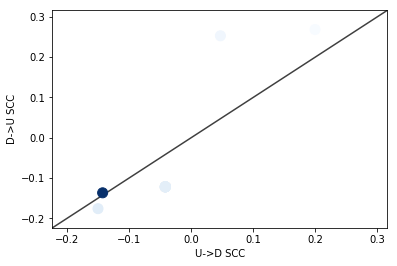

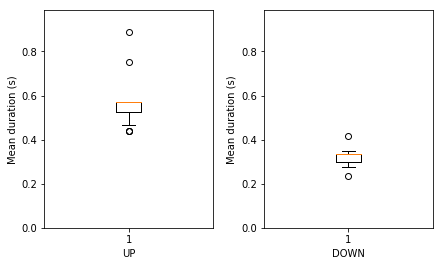

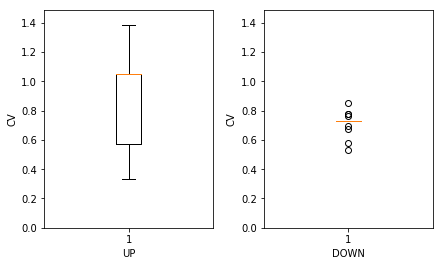

In [23]:
# Inputs:
freqData_file = 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/spiking_data/rounded_spikes_0.01/BWRat19_032413.csv'
sws_file = 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/UpDownTimes_data/BWRat19_032413/swsTimes.csv'
dt = 0.01
ma_window = 20
up_thresh = 0.8
down_thresh = 0.5
num_ups_min = 50 # SWS periods must have more than this number of up states for SCC to be calculated

ud_recording, du_recording, num_ups, mean_up_list, cv_up_list, mean_down_list, cv_down_list = segment_recording(freqData_file, sws_file, ma_window, up_thresh, down_thresh, num_ups_min, mean_cv = True)

plot_sccs(ud_recording, du_recording, num_ups)
mean_plot(mean_up_list, mean_down_list)
cv_plot(cv_up_list, cv_down_list)

0 952 561100
952 4935 561100
4935 9021 561100
9021 10170 561100
10170 10876 561100
10876 12746 561100
12746 18182 561100
18182 20923 561100
20923 24307 561100
24307 26806 561100
26806 33414 561100
33414 51389 561100
51389 88707 561100
88707 93804 561100
93804 129875 561100
129875 134198 561100
134198 141036 561100
141036 143068 561100
143068 146464 561100
146464 150229 561100
150229 154586 561100
154586 161188 561100
161188 165096 561100
165096 179795 561100
179795 199900 561100
199900 210697 561100
210697 224362 561100
224362 236253 561100
236253 244835 561100
244835 256459 561100
256459 261280 561100
261280 265814 561100
265814 288771 561100
288771 292768 561100
292768 294374 561100
294374 296099 561100
296099 308109 561100
308109 318234 561100
318234 328233 561100
328233 335432 561100
335432 336363 561100
No Crossings found
336363 336408 561100
336408 345054 561100
345054 365802 561100
365802 374710 561100
374710 381857 561100
381857 394281 561100
394281 398842 561100
398842 406359 

C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


510634 523942 561100
523942 529950 561100
529950 547004 561100
547004 561100 561100
Total number of SWS periods:  62
Minimum number of Up states to calculate SCC:  50
Number of plotted SWS periods with a large enough number of detected Up states:  38


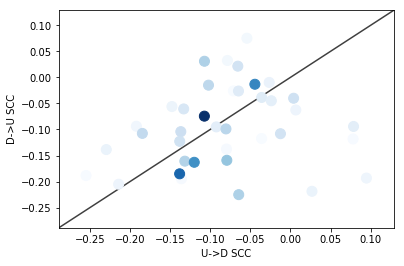

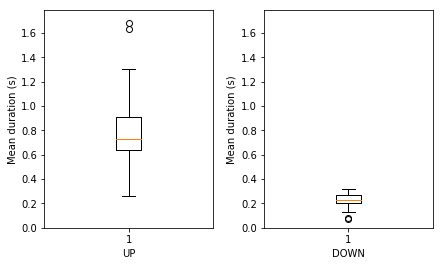

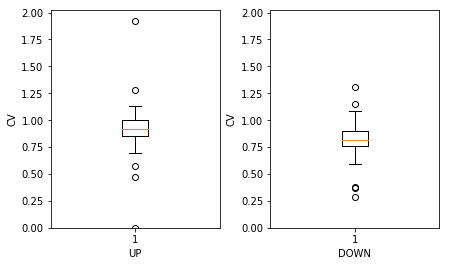

In [20]:
# Inputs:
freqData_file = 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/spiking_data/rounded_spikes_0.01/20140526_277um.csv'
sws_file = 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/UpDownTimes_data/20140526_277um/swsTimes.csv'
dt = 0.01
ma_window = 20
up_thresh = 0.8
down_thresh = 0.5
num_ups_min = 50 # SWS periods must have more than this number of up states for SCC to be calculated

ud_recording, du_recording, num_ups, mean_up_list, cv_up_list, mean_down_list, cv_down_list = segment_recording(freqData_file, sws_file, ma_window, up_thresh, down_thresh, num_ups_min, mean_cv = True)

plot_sccs(ud_recording, du_recording, num_ups)
mean_plot(mean_up_list, mean_down_list)
cv_plot(cv_up_list, cv_down_list)

Total number of SWS periods:  54
Minimum number of Up states to calculate SCC:  50
Number of plotted SWS periods with a large enough number of detected Up states:  44


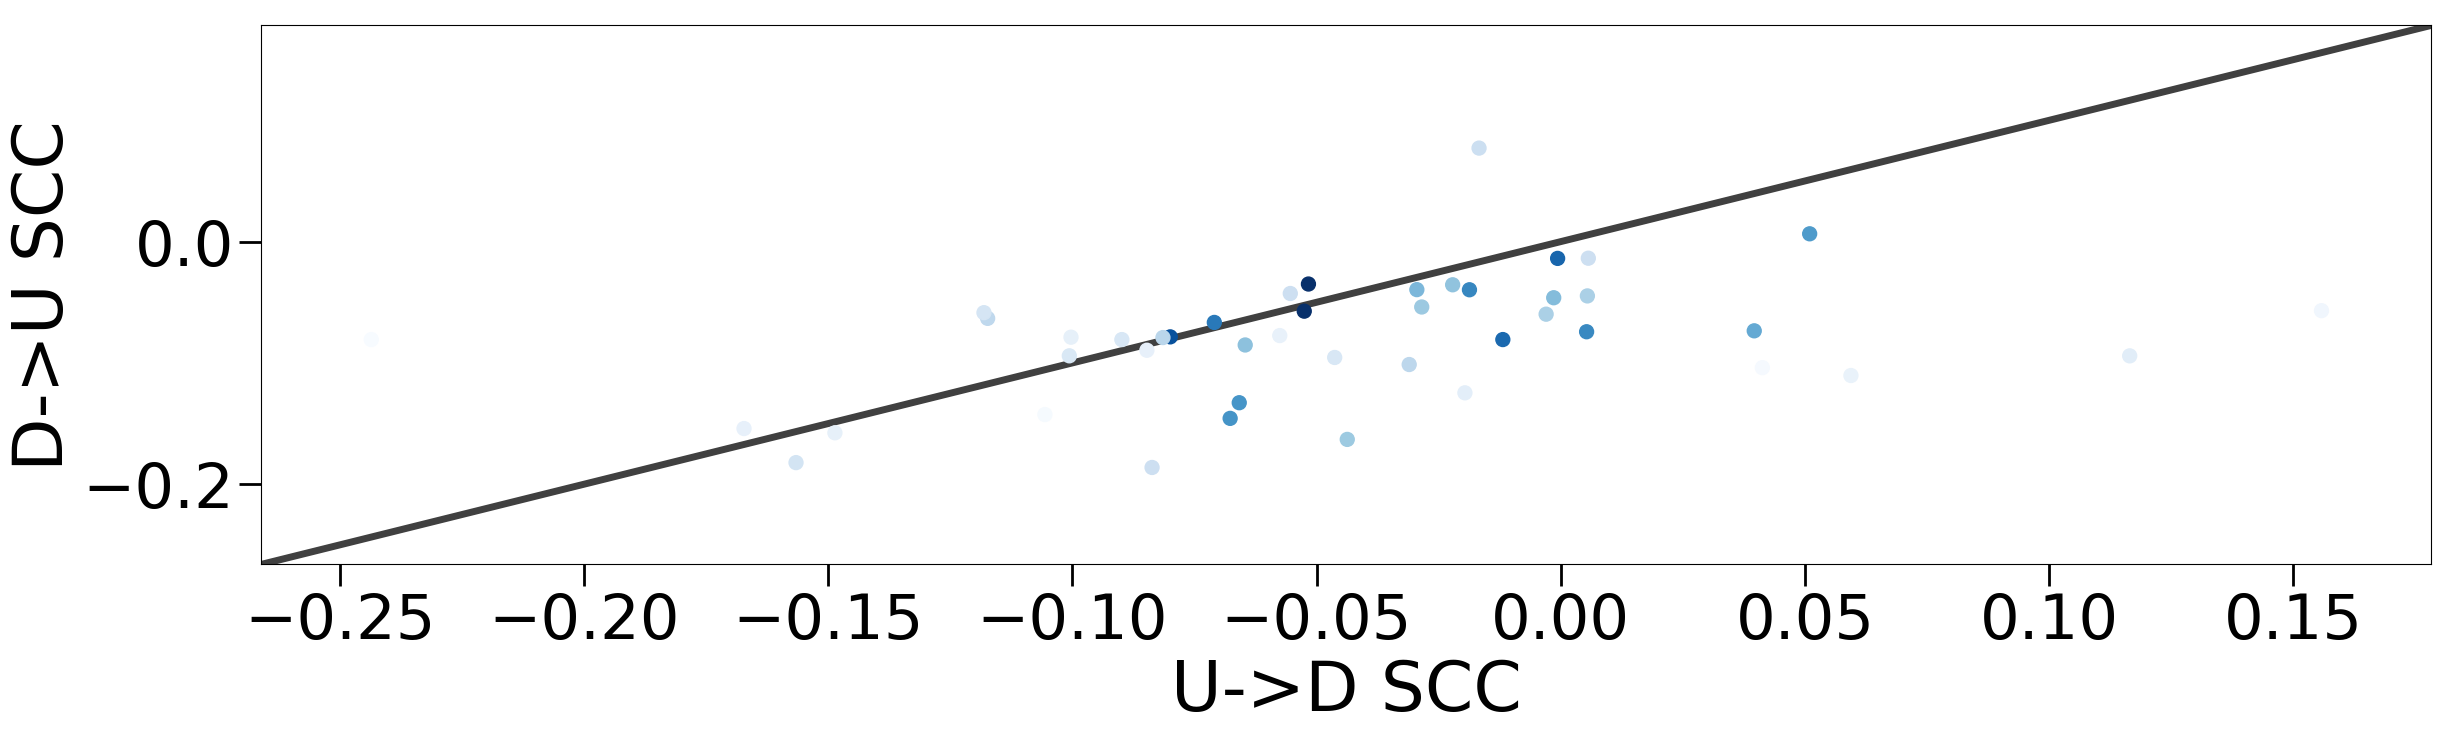

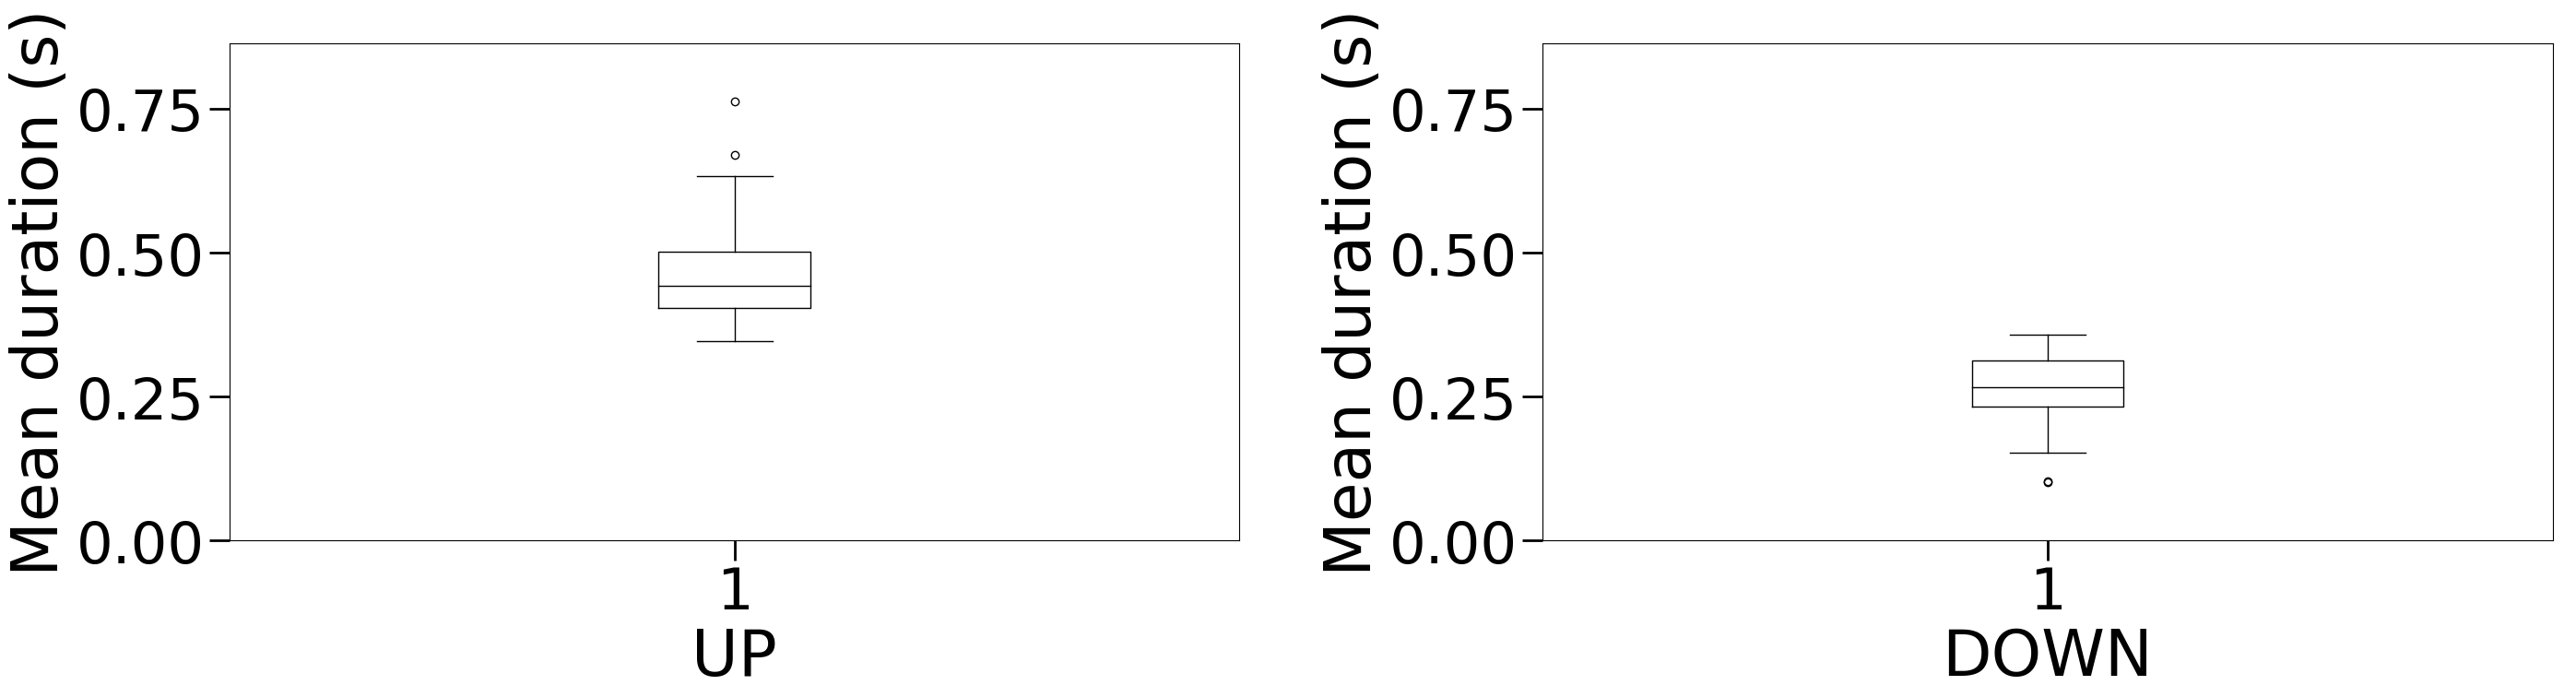

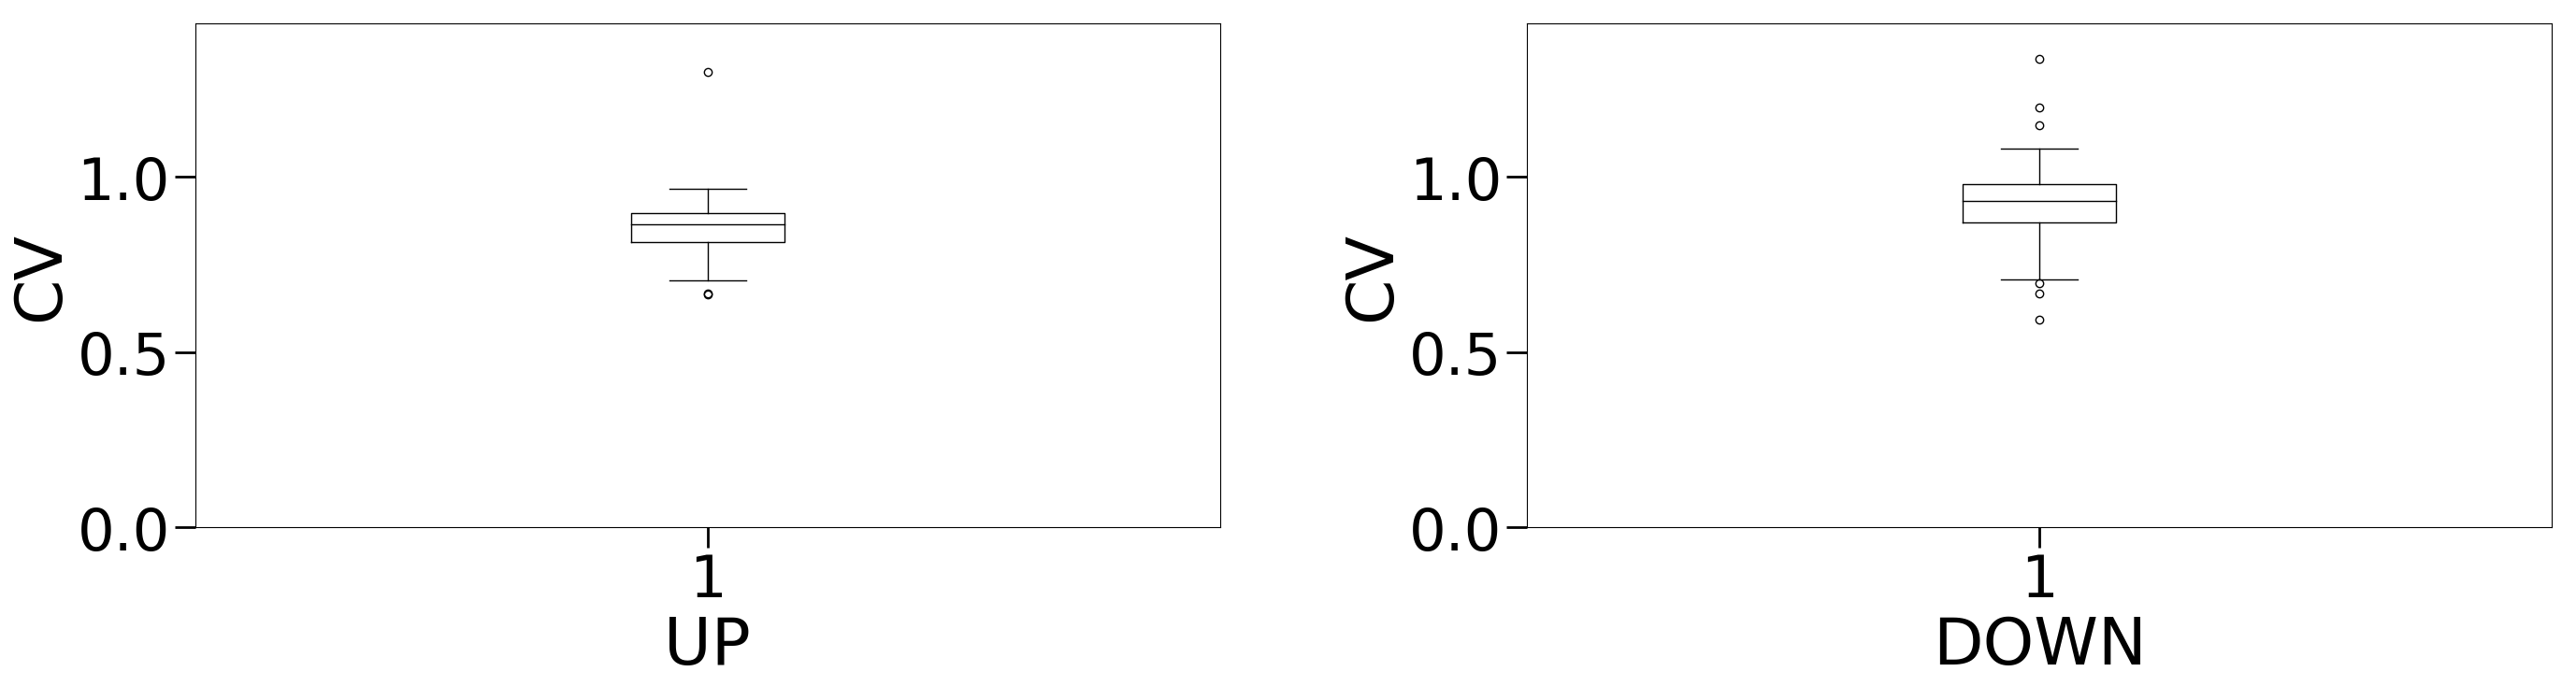

In [74]:
# Inputs:
freqData_file = 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/spiking_data/rounded_spikes_0.01/20140527_421um.csv'
sws_file = 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/UpDownTimes_data/20140527_421um/swsTimes.csv'
dt = 0.01
ma_window = 20
up_thresh = 0.8
down_thresh = 0.5
num_ups_min1 = 50 # SWS periods must have more than this number of up states for SCC to be calculated

ud_recording, du_recording, num_ups, mean_up_list, cv_up_list, mean_down_list, cv_down_list = segment_recording(freqData_file, sws_file, ma_window, up_thresh, down_thresh, num_ups_min, mean_cv = True)

plot_sccs(ud_recording, du_recording, num_ups)
mean_plot(mean_up_list, mean_down_list)
cv_plot(cv_up_list, cv_down_list)


No Crossings found
No Crossings found


C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Total number of SWS periods:  46
Minimum number of Up states to calculate SCC:  50
Number of plotted SWS periods with a large enough number of detected Up states:  26


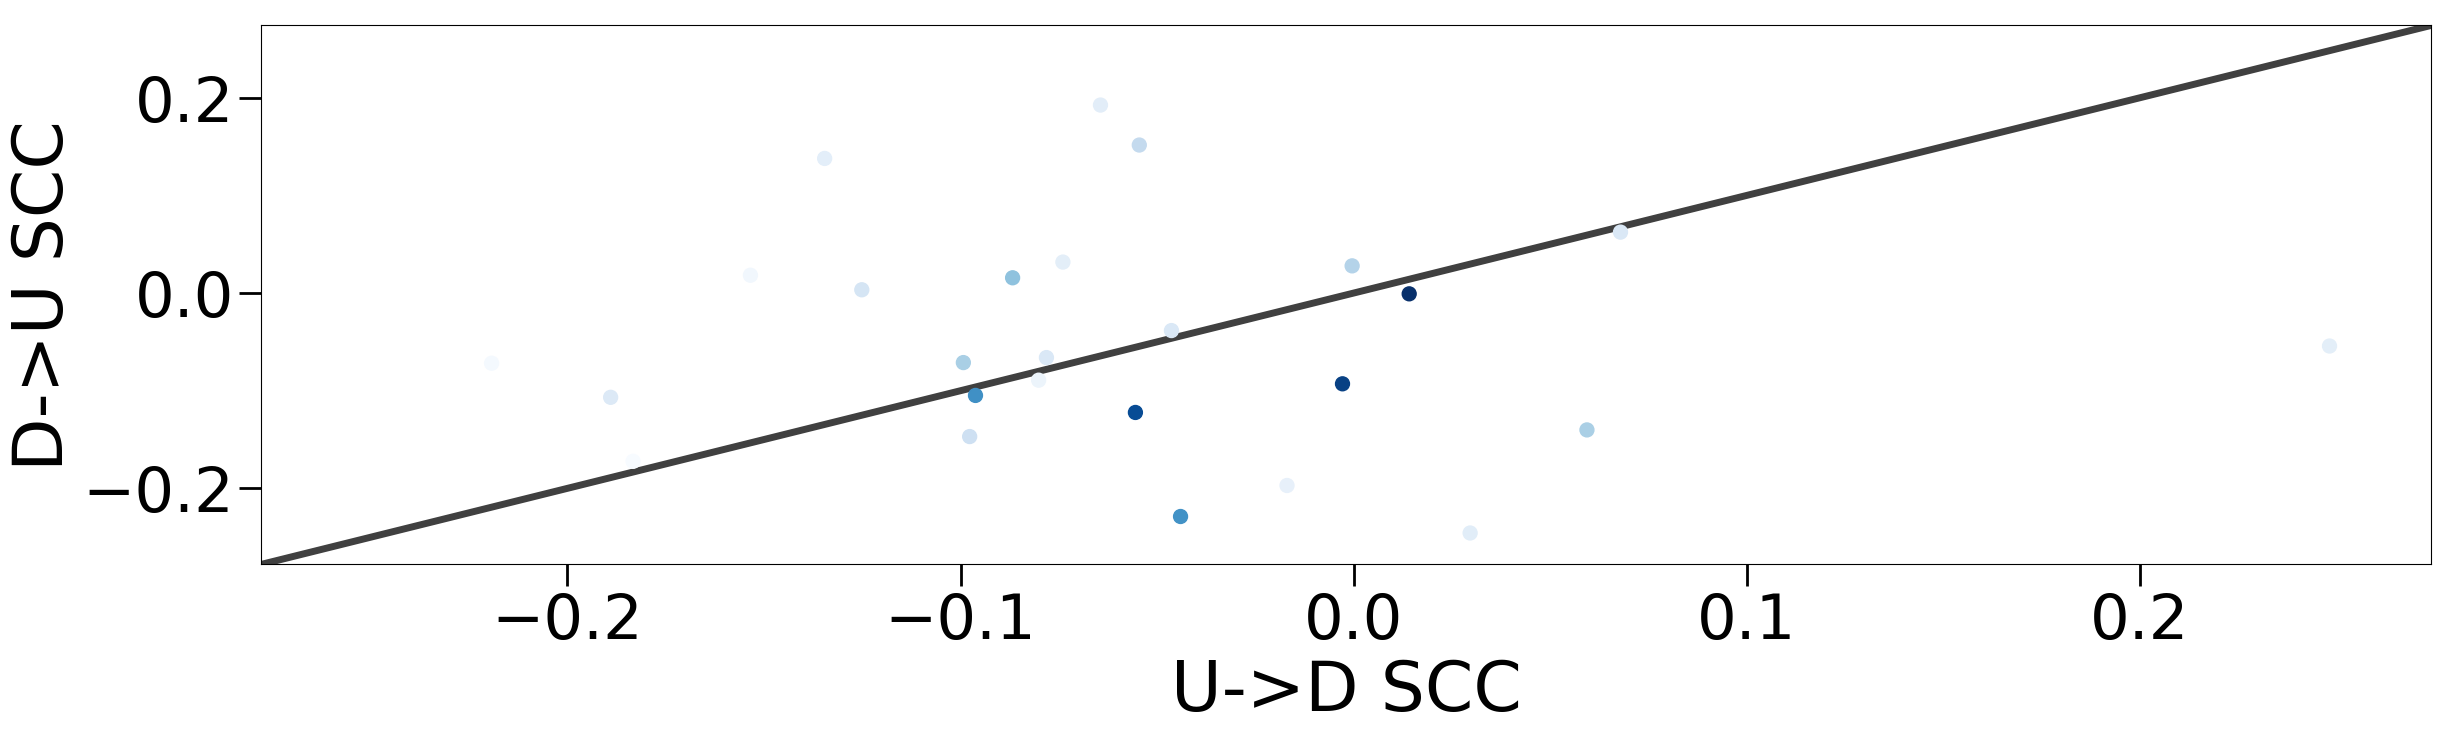

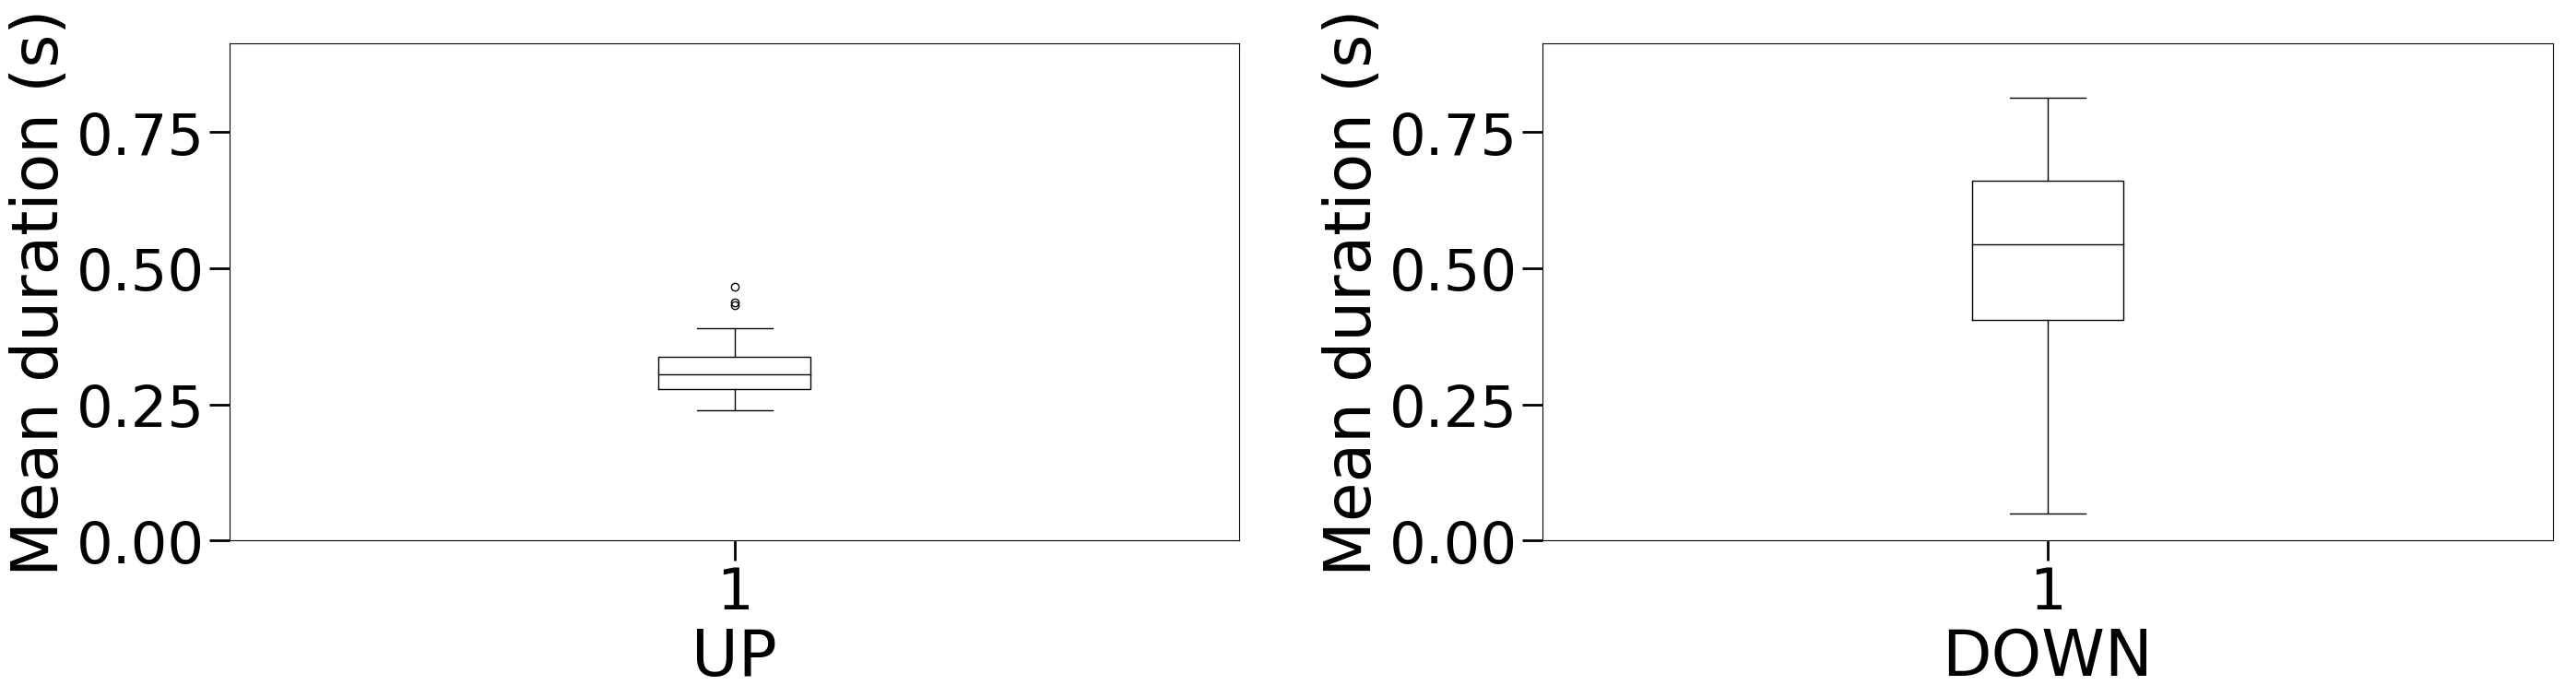

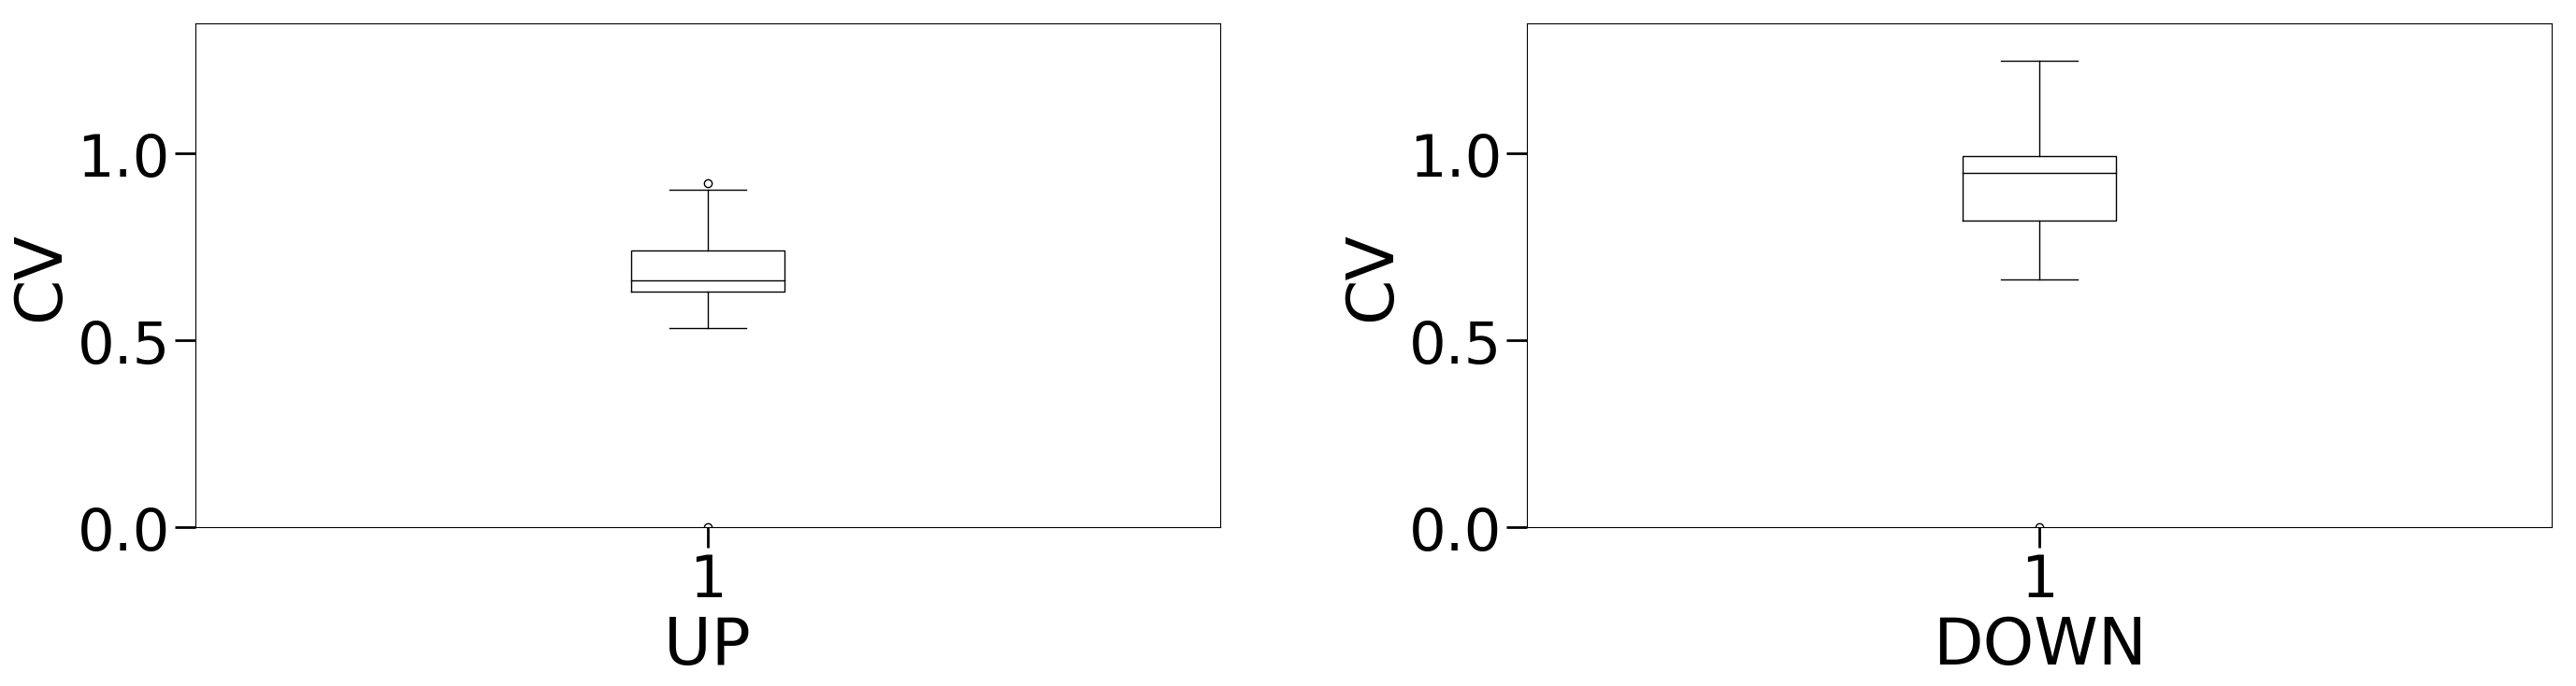

In [75]:
# Inputs:
freqData_file = 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/spiking_data/rounded_spikes_0.01/BWRat17_121912.csv'
sws_file = 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/UpDownTimes_data/BWRat17_121912/swsTimes.csv'
dt = 0.01
ma_window = 20
up_thresh = 0.8
down_thresh = 0.5
num_ups_min = 50 # SWS periods must have more than this number of up states for SCC to be calculated

ud_recording, du_recording, num_ups, mean_up_list, cv_up_list, mean_down_list, cv_down_list = segment_recording(freqData_file, sws_file, ma_window, up_thresh, down_thresh, num_ups_min, mean_cv = True)

plot_sccs(ud_recording, du_recording, num_ups)
mean_plot(mean_up_list, mean_down_list)
cv_plot(cv_up_list, cv_down_list)


No Crossings found


C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


No Crossings found
No Crossings found
No Crossings found
Total number of SWS periods:  69
Minimum number of Up states to calculate SCC:  50
Number of plotted SWS periods with a large enough number of detected Up states:  40


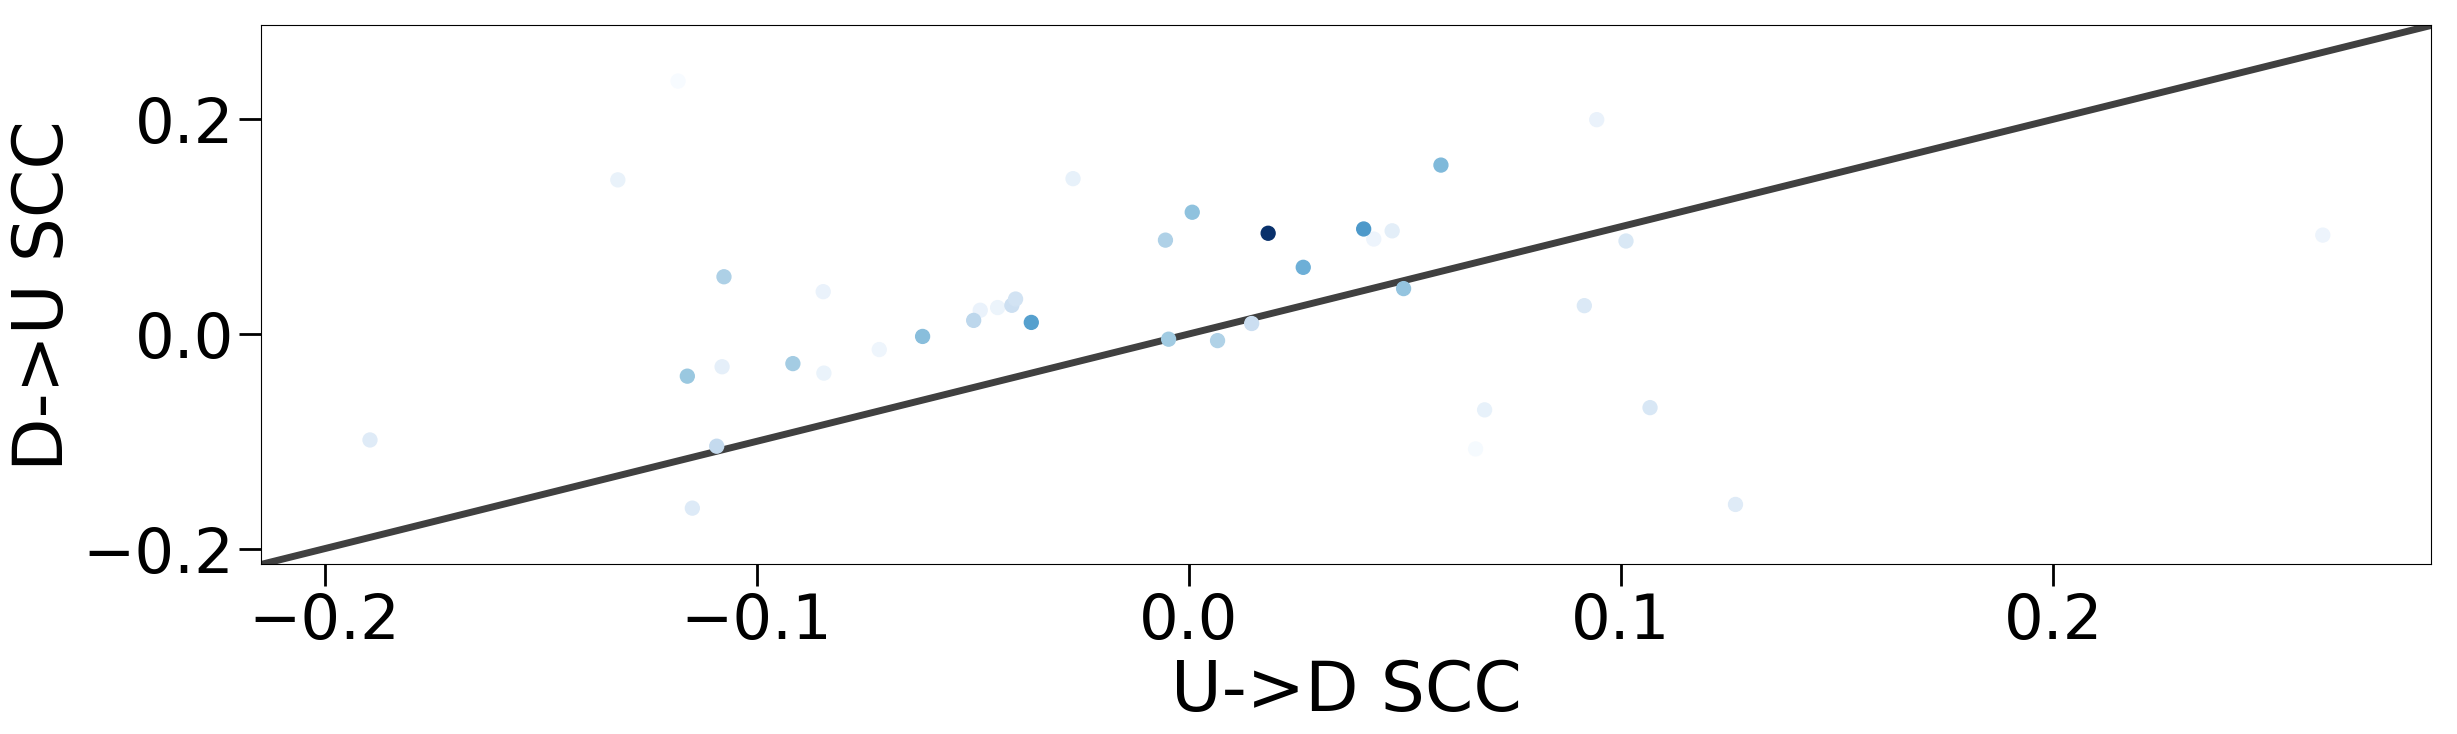

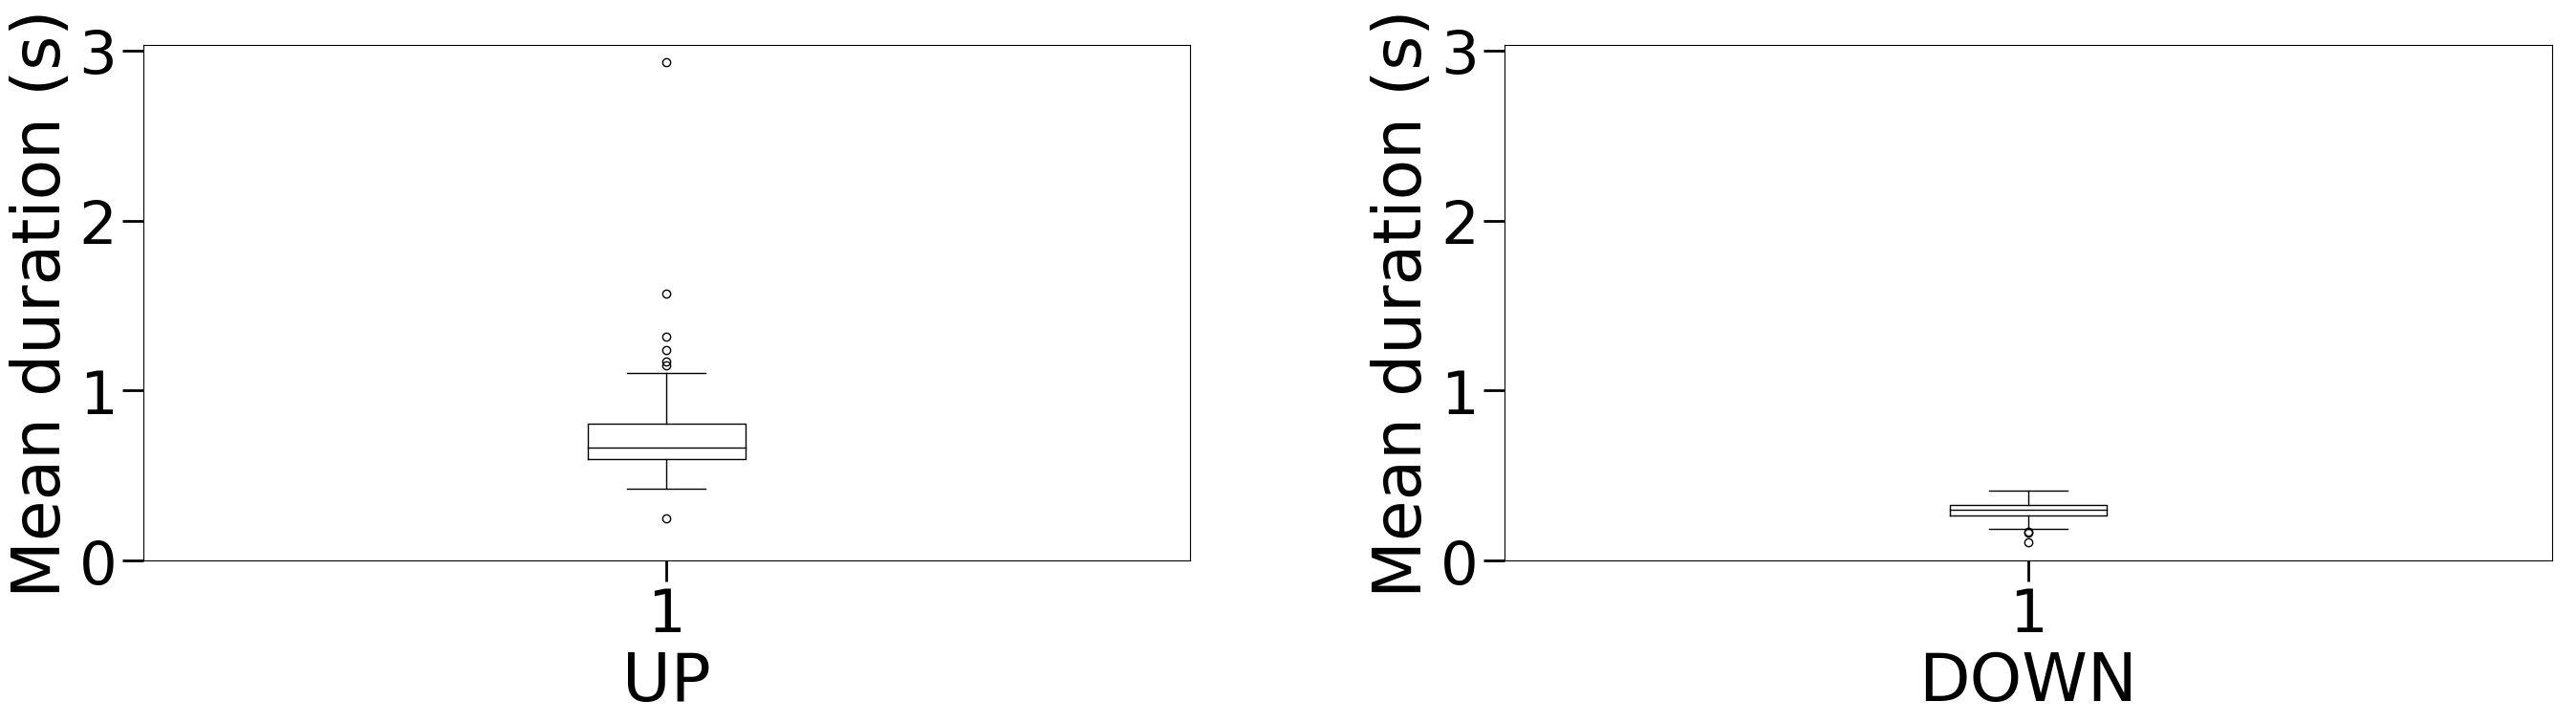

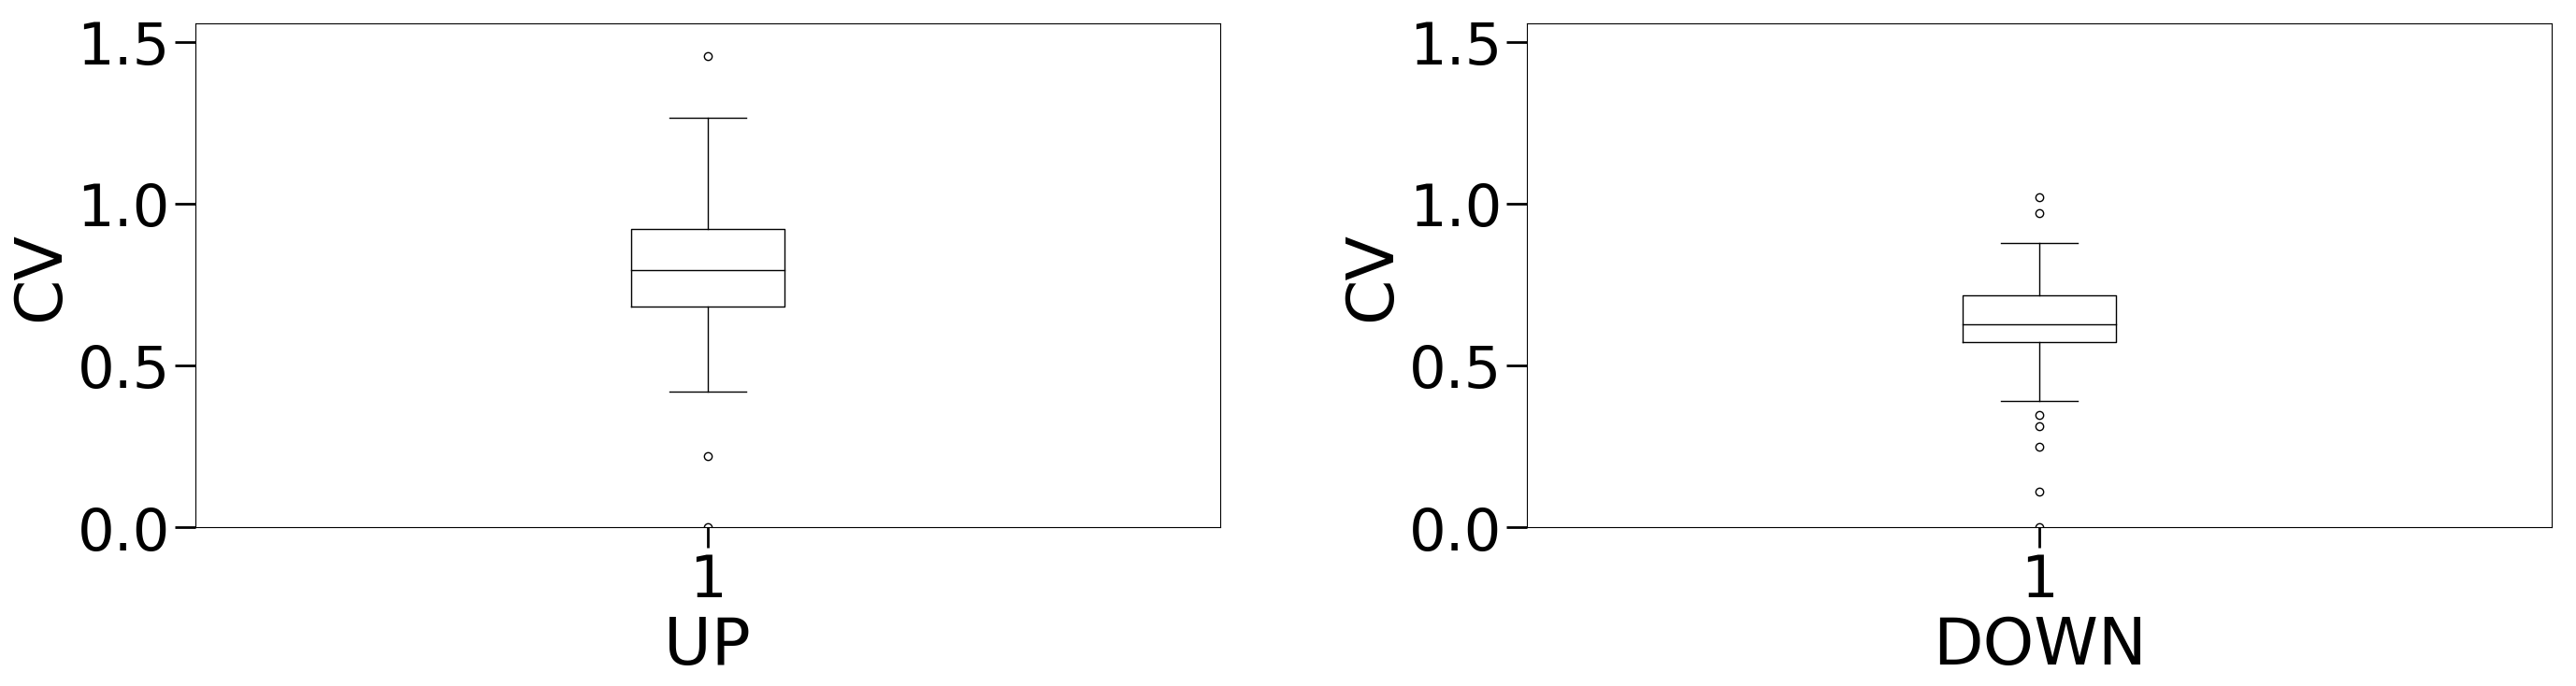

In [76]:
# Inputs:
freqData_file = 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/spiking_data/rounded_spikes_0.01/Dino_061814_mPFC.csv'
sws_file = 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/UpDownTimes_data/Dino_061814_mPFC/swsTimes.csv'
dt = 0.01
ma_window = 20
up_thresh = 0.8
down_thresh = 0.5
num_ups_min = 50 # SWS periods must have more than this number of up states for SCC to be calculated

ud_recording, du_recording, num_ups, mean_up_list, cv_up_list, mean_down_list, cv_down_list = segment_recording(freqData_file, sws_file, ma_window, up_thresh, down_thresh, num_ups_min, mean_cv = True)

plot_sccs(ud_recording, du_recording, num_ups)
mean_plot(mean_up_list, mean_down_list)
cv_plot(cv_up_list, cv_down_list)


C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Total number of SWS periods:  92
Minimum number of Up states to calculate SCC:  50
Number of plotted SWS periods with a large enough number of detected Up states:  61


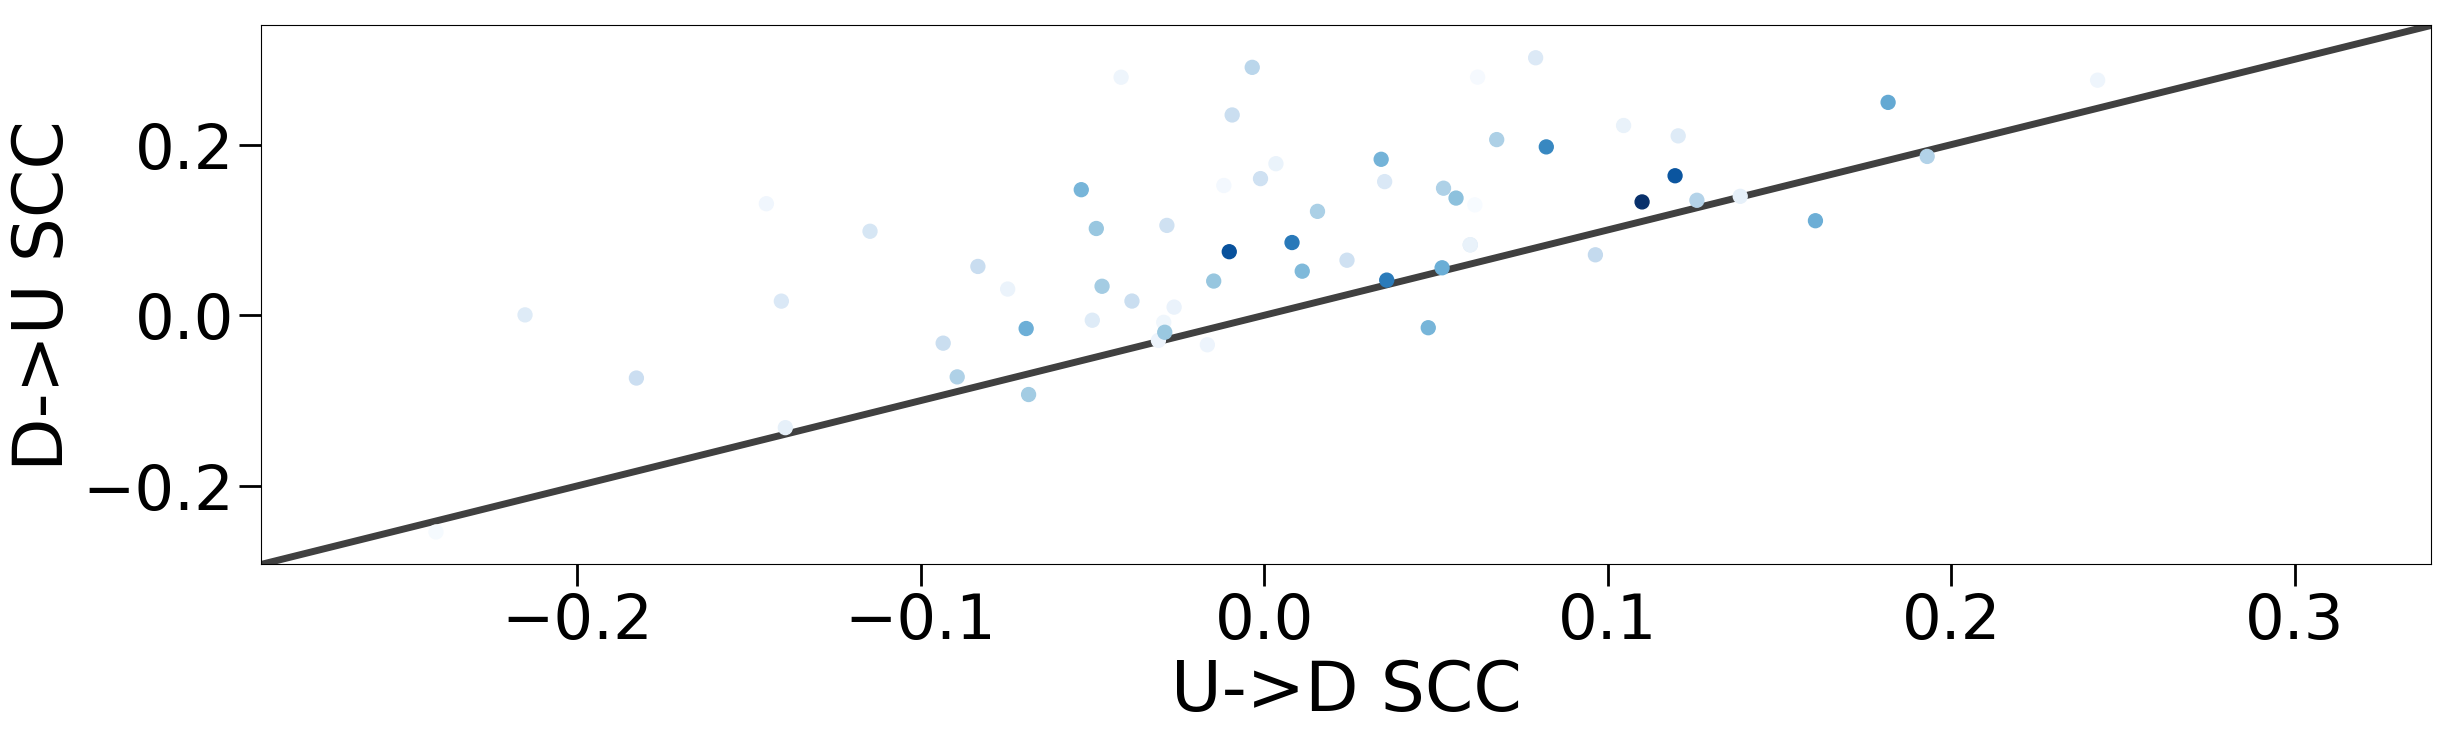

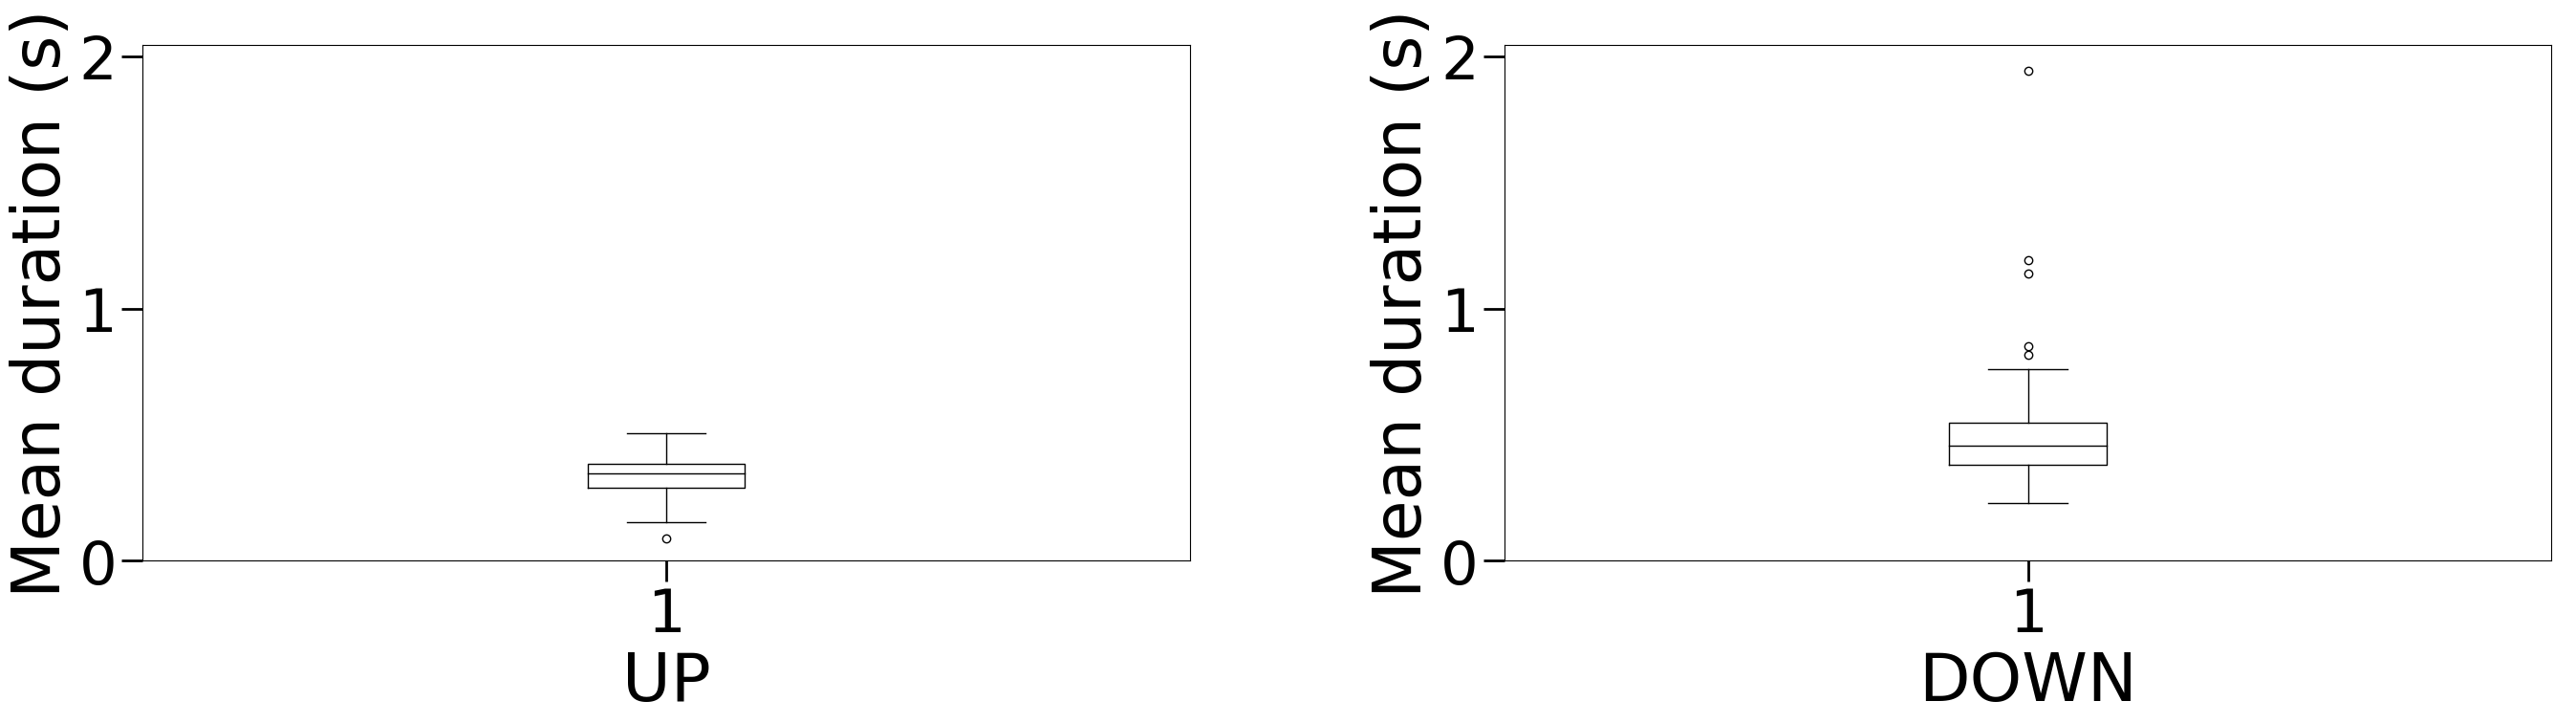

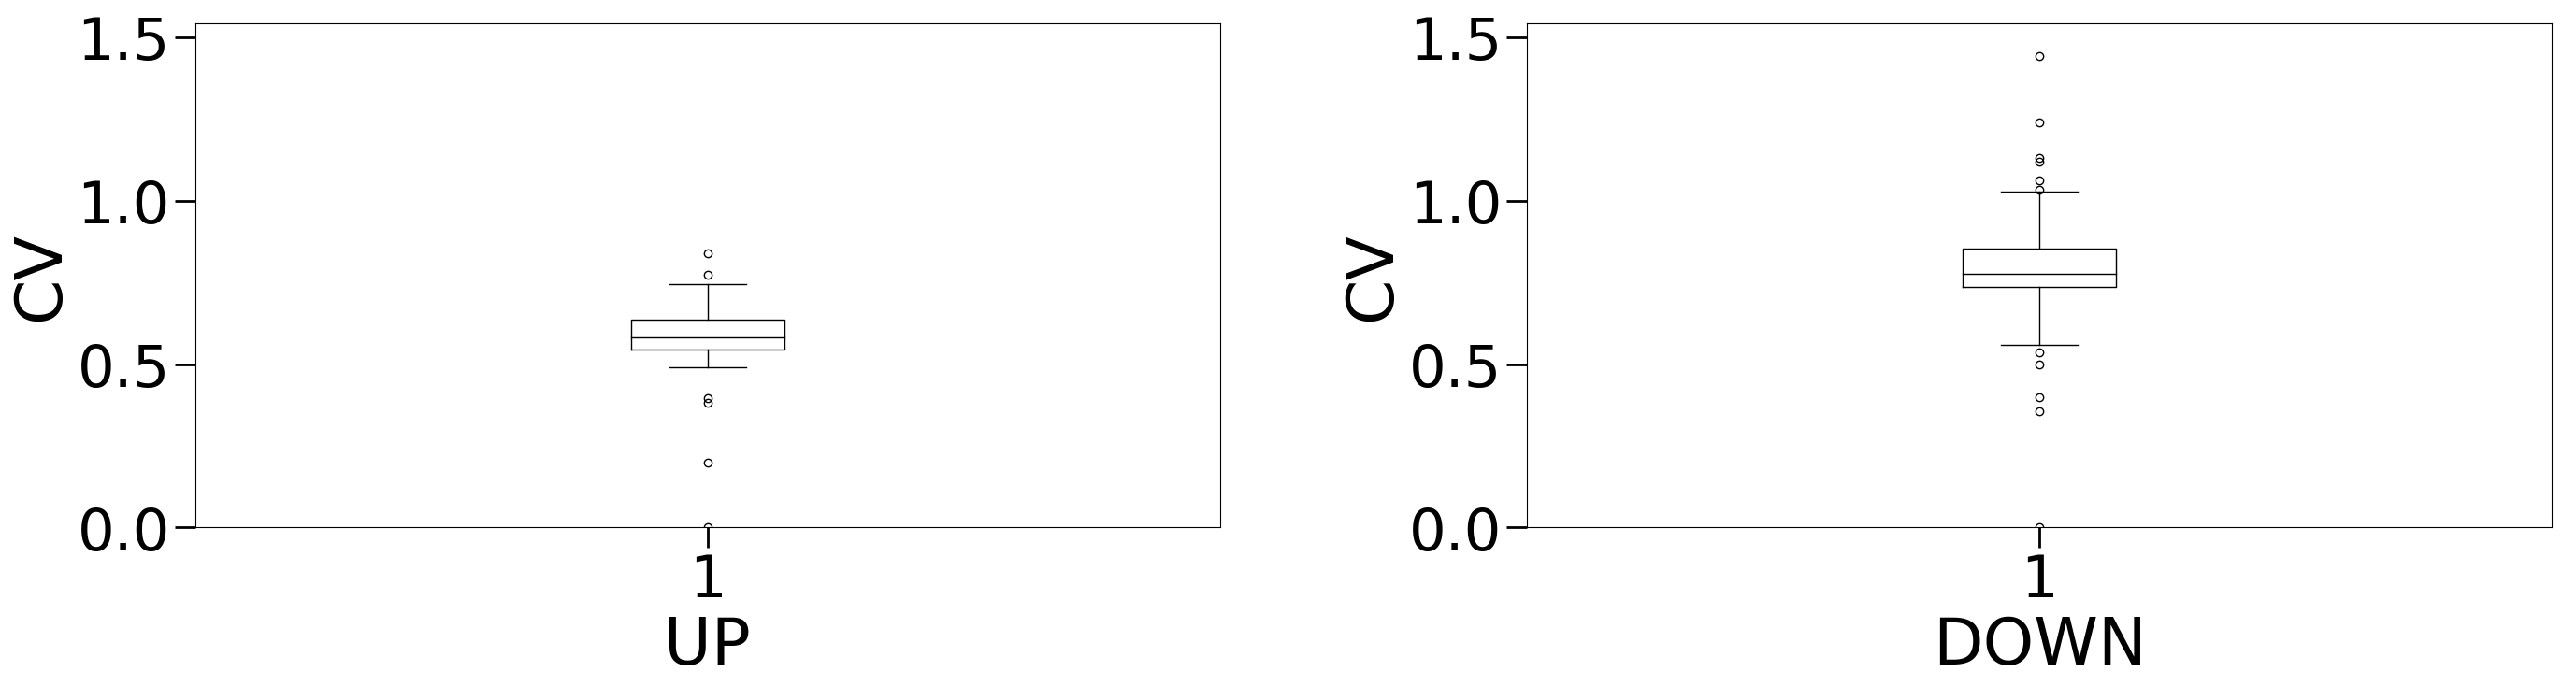

In [77]:
# Inputs:
freqData_file = 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/spiking_data/rounded_spikes_0.01/Splinter_020515.csv'
sws_file = 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/UpDownTimes_data/Splinter_020515/swsTimes.csv'
dt = 0.01
ma_window = 20
up_thresh = 0.8
down_thresh = 0.5
num_ups_min = 50 # SWS periods must have more than this number of up states for SCC to be calculated

ud_recording, du_recording, num_ups, mean_up_list, cv_up_list, mean_down_list, cv_down_list = segment_recording(freqData_file, sws_file, ma_window, up_thresh, down_thresh, num_ups_min, mean_cv = True)

plot_sccs(ud_recording, du_recording, num_ups)
mean_plot(mean_up_list, mean_down_list)
cv_plot(cv_up_list, cv_down_list)


No Crossings found


C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


No Crossings found
No Crossings found
No Crossings found
No Crossings found
Total number of SWS periods:  90
Minimum number of Up states to calculate SCC:  50
Number of plotted SWS periods with a large enough number of detected Up states:  48


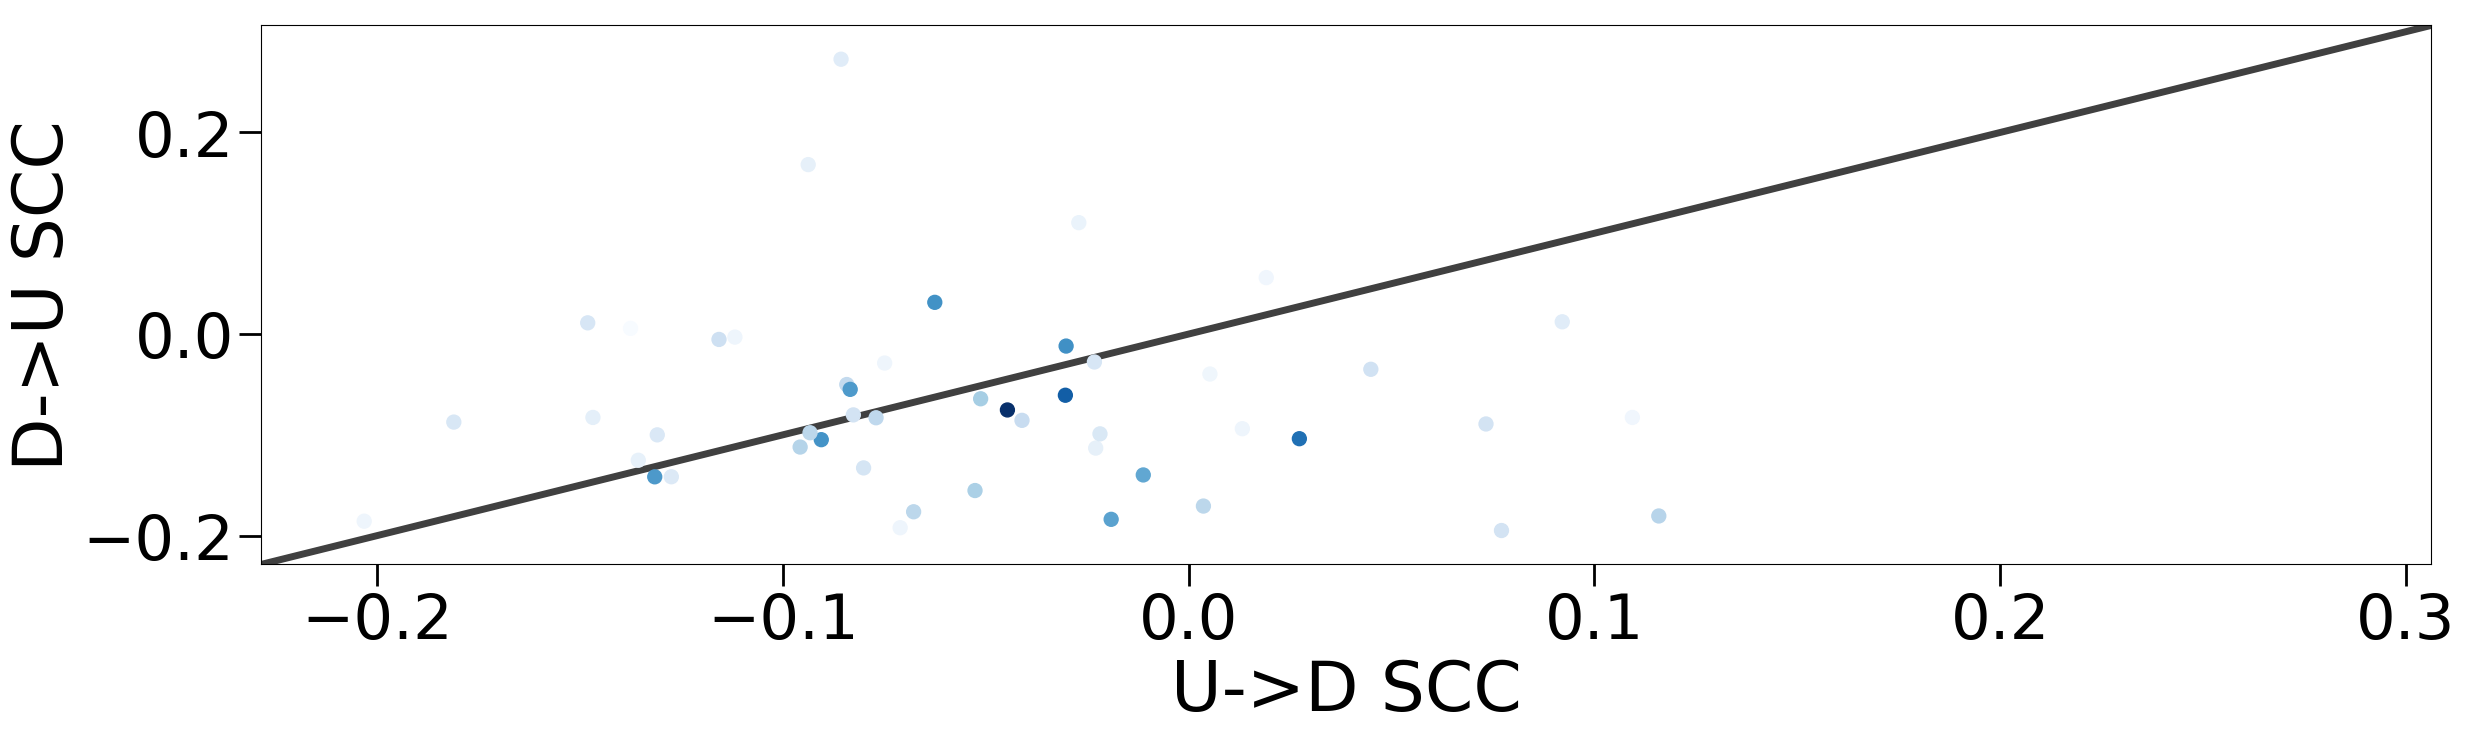

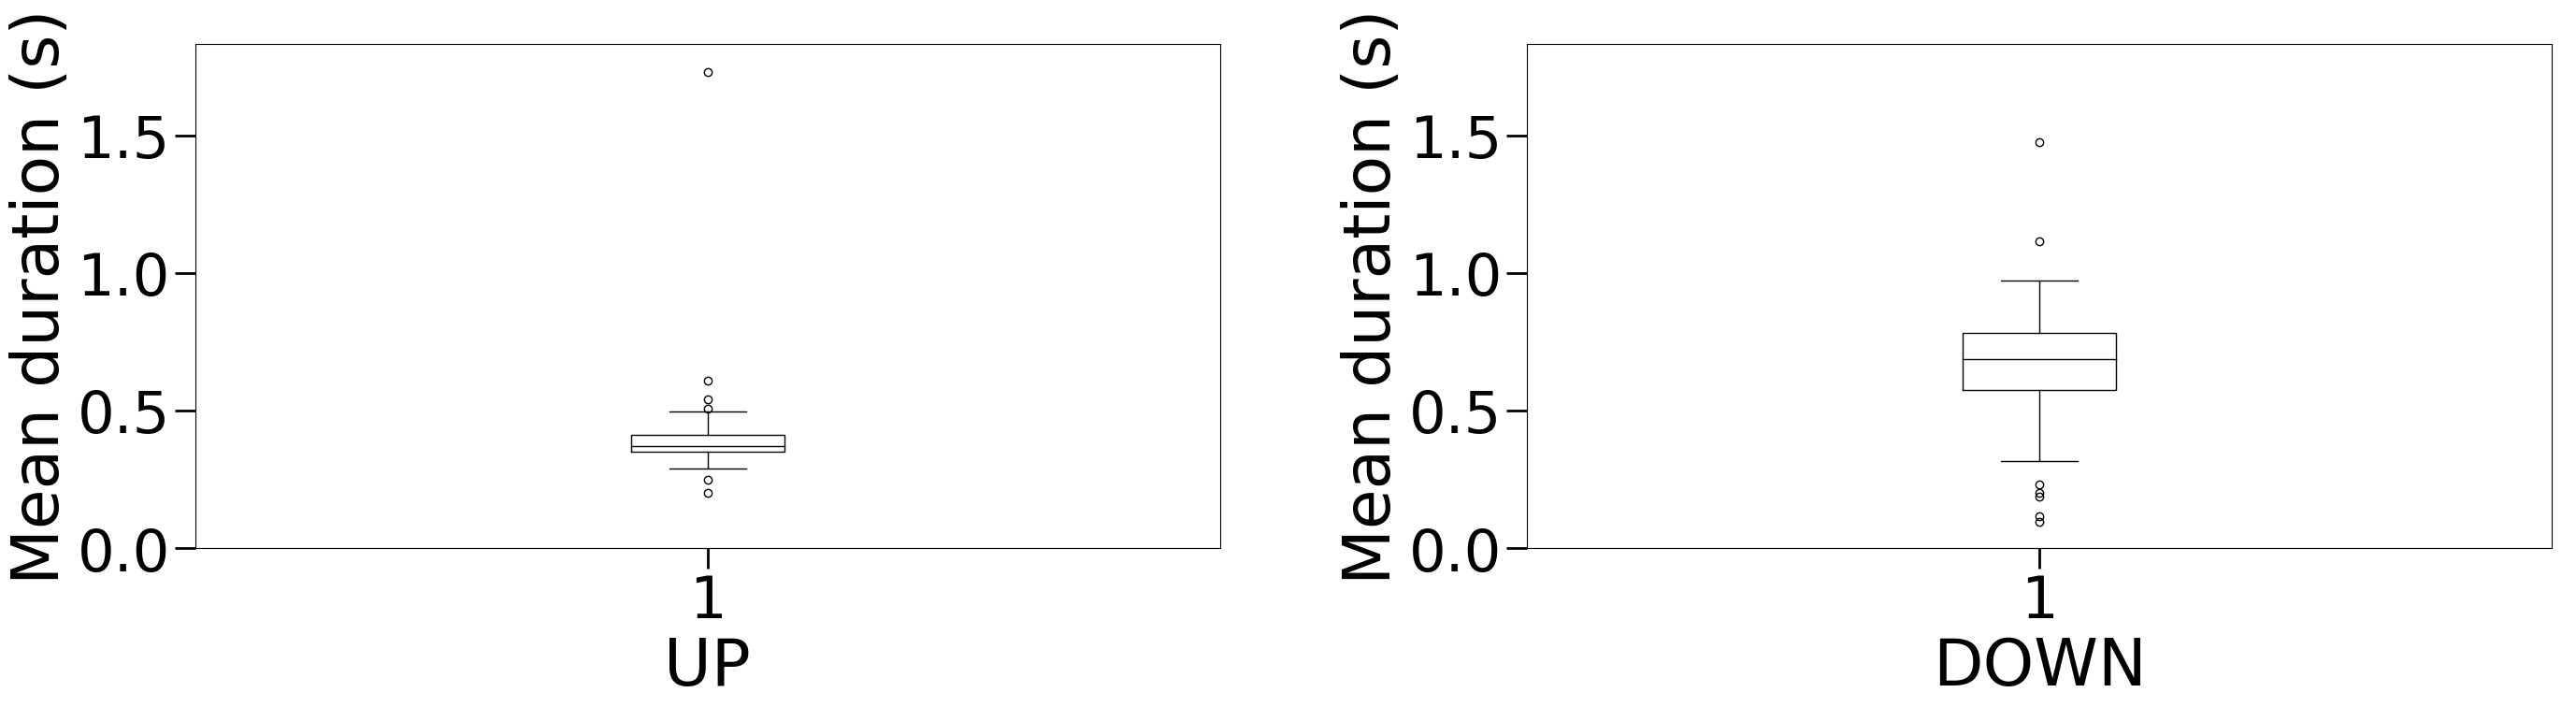

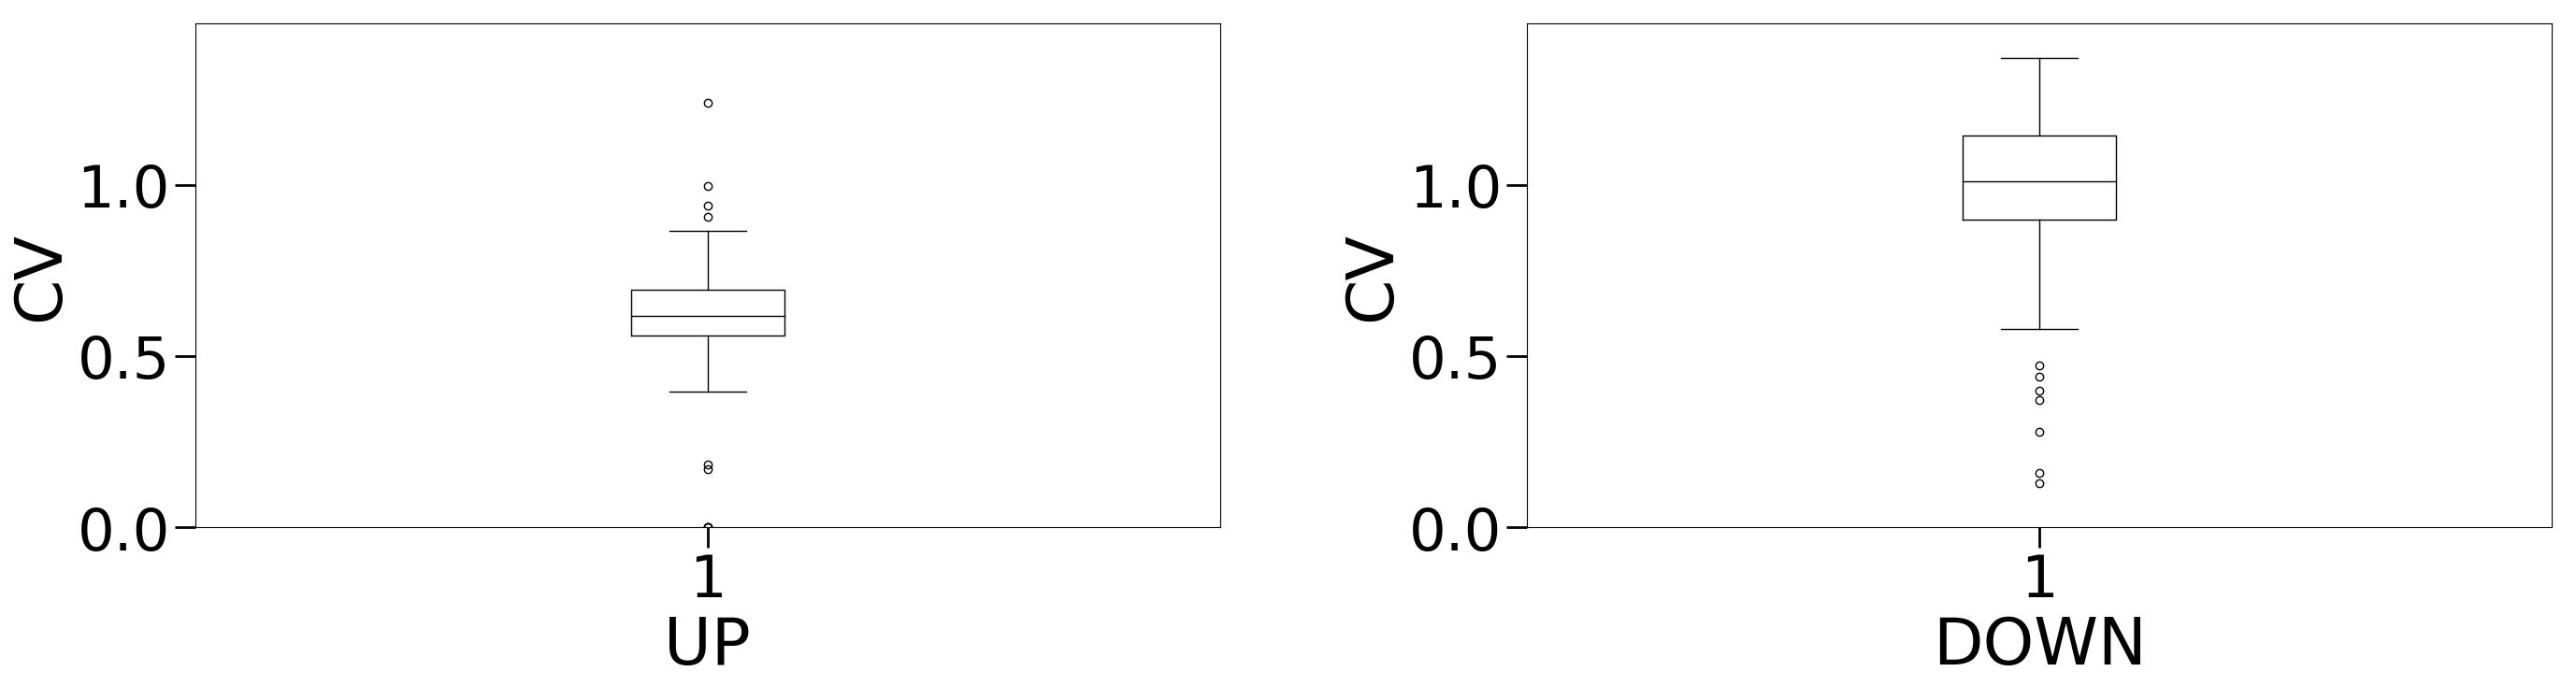

In [78]:
# Inputs:
freqData_file = 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/spiking_data/rounded_spikes_0.01/Templeton_032415.csv'
sws_file = 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/UpDownTimes_data/Templeton_032415/swsTimes.csv'
dt = 0.01
ma_window = 20
up_thresh = 0.8
down_thresh = 0.5
num_ups_min = 50 # SWS periods must have more than this number of up states for SCC to be calculated

ud_recording, du_recording, num_ups, mean_up_list, cv_up_list, mean_down_list, cv_down_list = segment_recording(freqData_file, sws_file, ma_window, up_thresh, down_thresh, num_ups_min, mean_cv = True)

plot_sccs(ud_recording, du_recording, num_ups)
mean_plot(mean_up_list, mean_down_list)
cv_plot(cv_up_list, cv_down_list)


In [6]:
# Segment lots of recordings using manually selected thresholds and plot SCCs for each recording

# For every recording:
    # Load the population frequency data via the column vector. Also load the 2019 SWS interval information, which I have for some recordings and can get via sws_start_stop.m.
    # For every SWS interval:
        # Check that it has the minimum number of Up/Down states
        # Smooth the spikes with a large moving average
        # Using the manually set thresholds, segment the data and calculate a list of Up durations and a list of Down durations
        # Calculate the U->D and D->U SCCs and store them
    # Calculate the mean of the U->D SCCs and D->U SCCs from all the SWS intervals, and store these two numbers
        # NOTE: Later, I started calculated SCCs using all the data, rather than calculating the mean. Use updated version like
        # in Levenstein segmentation statistics or HMM segmentation statistics files
# Use matplotlib to create plots with U->D and D->U SCCs on the different axes, continuous color based on number of states detected within period, and the y=x line plotted

def segment_scc(ma_window, up_thresh, down_thresh, num_ups_min, dt, freq_root, sws_root):
    mean_ud_sccs = []
    mean_du_sccs = []
    
    mean_mean_up = []
    mean_cv_up = []
    mean_mean_down = []
    mean_cv_down = []

    # For every recording:
    for filename in os.listdir(freq_root):
        freqData_file = os.path.join(freq_root, filename)
        sws_file = os.path.join(sws_root, filename[:-4], 'swsTimes.csv') #make sure to get rid of '.csv' from filename
        # Segment the data and calculate SCCs
        ud_recording, du_recording, num_ups, mean_up_list, cv_up_list, mean_down_list, cv_down_list = segment_recording(freqData_file, sws_file, ma_window, up_thresh, down_thresh, num_ups_min, mean_cv = True)
        print("Total number of long enough sws periods: ", len(ud_recording))
        
        # Convert everything to numpy array
        np_ud_recording = np.array(ud_recording)
        np_du_recording = np.array(du_recording)
        np_num_ups = np.array(num_ups)
        np_mean_up_list = np.array(mean_up_list)
        np_cv_up_list = np.array(cv_up_list)
        np_mean_down_list = np.array(mean_down_list)
        np_cv_down_list = np.array(cv_down_list)
        
    
        if len(ud_recording) > 0:
            # Calculate the mean SCCs:
            mean_ud = np.mean(np_ud_recording)
            mean_du = np.mean(np_du_recording)
            mean_ud_sccs.append(mean_ud)
            mean_du_sccs.append(mean_du)
        
            # Calculate the mean Means and mean CVs:
            mean_up = np.mean(mean_up_list)
            mean_mean_up.append(mean_up)
            cv_up = np.mean(cv_up_list)
            mean_cv_up.append(cv_up)
            mean_down = np.mean(mean_down_list)
            mean_mean_down.append(mean_down)
            cv_down = np.mean(cv_down_list)
            mean_cv_down.append(cv_down)
            
    return mean_ud_sccs, mean_du_sccs, mean_mean_up, mean_mean_down, mean_cv_up, mean_cv_down


No Crossings found
Total number of SWS periods:  62
Minimum number of Up states to calculate SCC:  50


C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Total number of long enough sws periods:  38
Total number of SWS periods:  54
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  44
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
Total number of SWS periods:  47
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  25
No Crossings found
Total number of SWS periods:  105
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  81
No Crossings found
No Crossings found
Total number of SWS periods:  46
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  26
Total number of SWS periods:  18
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  11
Total number of SWS periods:  17
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods: 

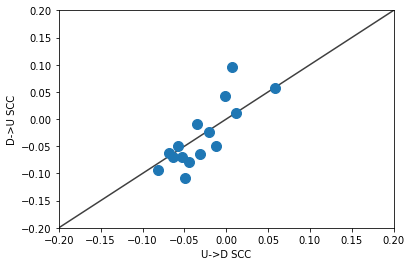

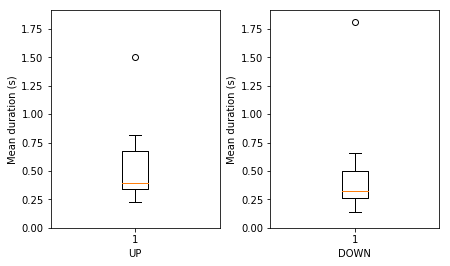

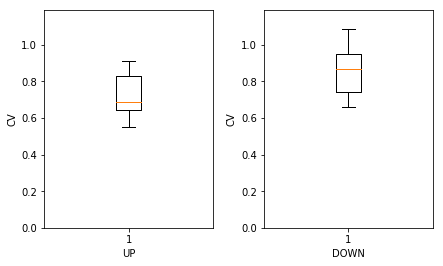

In [6]:
mean_ud_sccs, mean_du_sccs, mean_mean_up, mean_mean_down, mean_cv_up, mean_cv_down = segment_scc(20, 0.8, 0.5, 50, 0.01, 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/spiking_data/rounded_spikes_0.01', 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/UpDownTimes_data')

plot_sccs(mean_ud_sccs, mean_du_sccs)
mean_plot(mean_mean_up, mean_mean_down)
cv_plot(mean_cv_up, mean_cv_down)

No Crossings found
No Crossings found
Total number of SWS periods:  62
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  35


C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Total number of SWS periods:  54
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  42
No Crossings found
No Crossings found
Total number of SWS periods:  47
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  30
No Crossings found
Total number of SWS periods:  105
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  75
No Crossings found
No Crossings found
No Crossings found
No Crossings found
Total number of SWS periods:  46
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  4
Total number of SWS periods:  18
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  10
Total number of SWS periods:  17
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  11
No Crossings found
Total number of SWS periods:  16
Minimum number of Up states to calculate SCC:  

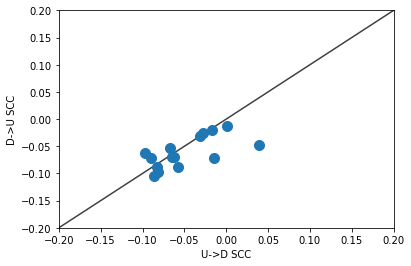

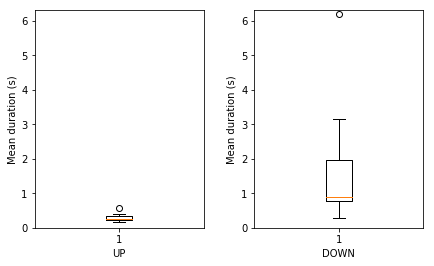

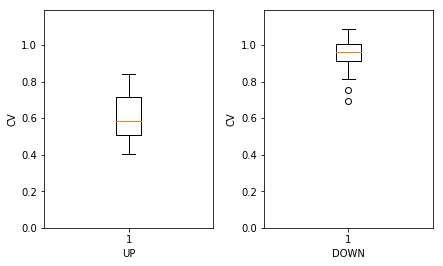

In [7]:
mean_ud_sccs, mean_du_sccs, mean_mean_up, mean_mean_down, mean_cv_up, mean_cv_down = segment_scc(20, 1.5, 1, 50, 0.01, 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/spiking_data/rounded_spikes_0.01', 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/UpDownTimes_data')

plot_sccs(mean_ud_sccs, mean_du_sccs)
mean_plot(mean_mean_up, mean_mean_down)
cv_plot(mean_cv_up, mean_cv_down)

No Crossings found


C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Total number of SWS periods:  62
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  34
Total number of SWS periods:  54
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  43
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
Total number of SWS periods:  47
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  25
No Crossings found
No Crossings found
Total number of SWS periods:  46
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  22
Total number of SWS periods:  18
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  11
Total number of SWS periods:  17
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  12
No Crossings found
No Crossings found
Total number of SWS per

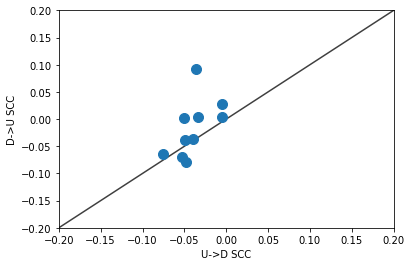

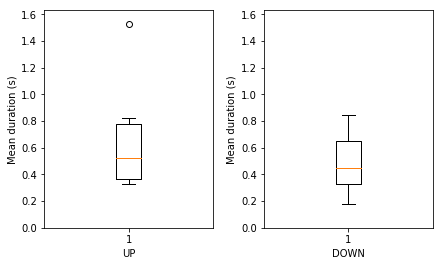

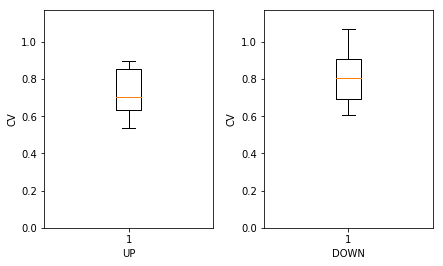

In [8]:
mean_ud_sccs, mean_du_sccs, mean_mean_up, mean_mean_down, mean_cv_up, mean_cv_down = segment_scc(20, 1, 0.5, 50, 0.01, 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/spiking_data/rounded_spikes_0.01', 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/UpDownTimes_data')

plot_sccs(mean_ud_sccs, mean_du_sccs)
mean_plot(mean_mean_up, mean_mean_down)
cv_plot(mean_cv_up, mean_cv_down)

No Crossings found


C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Total number of SWS periods:  62
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  41
Total number of SWS periods:  54
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  44
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
Total number of SWS periods:  47
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  25
No Crossings found
No Crossings found
Total number of SWS periods:  46
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  31
Total number of SWS periods:  18
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  14
Total number of SWS periods:  17
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  12
No Crossings found
No Crossings found
Total number of SWS per

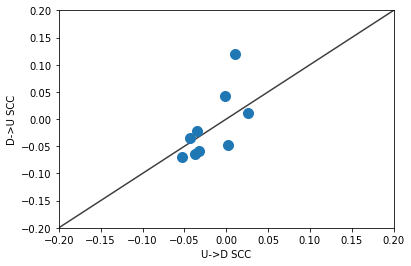

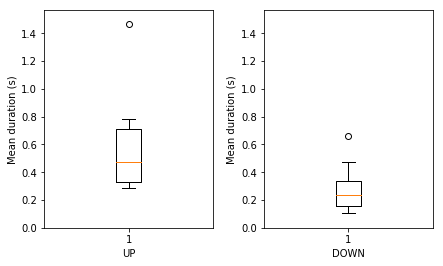

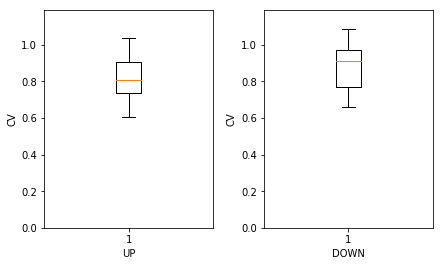

In [9]:
mean_ud_sccs, mean_du_sccs, mean_mean_up, mean_mean_down, mean_cv_up, mean_cv_down = segment_scc(20, 0.6, 0.5, 50, 0.01, 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/spiking_data/rounded_spikes_0.01', 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/UpDownTimes_data')

plot_sccs(mean_ud_sccs, mean_du_sccs)
mean_plot(mean_mean_up, mean_mean_down)
cv_plot(mean_cv_up, mean_cv_down)

Total number of SWS periods:  62
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  46
Total number of SWS periods:  54
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  47
No Crossings found
No Crossings found
No Crossings found


C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


No Crossings found
No Crossings found
Total number of SWS periods:  47
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  27
No Crossings found
No Crossings found
Total number of SWS periods:  46
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  28
Total number of SWS periods:  18
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  12
Total number of SWS periods:  17
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  12
Total number of SWS periods:  35
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  27
No Crossings found
No Crossings found
No Crossings found
Total number of SWS periods:  69
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  47
Total number of SWS periods:  92
Minimum number of Up states to calculate SCC:  50
Total number of 

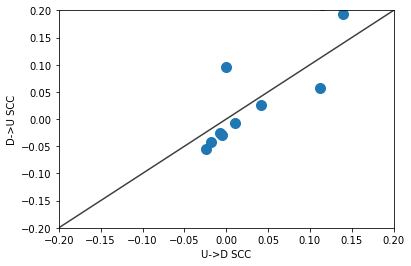

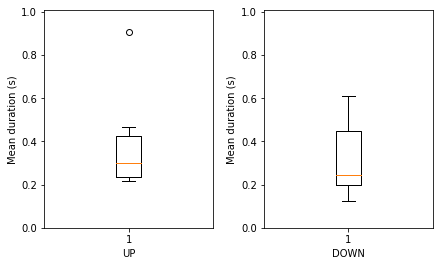

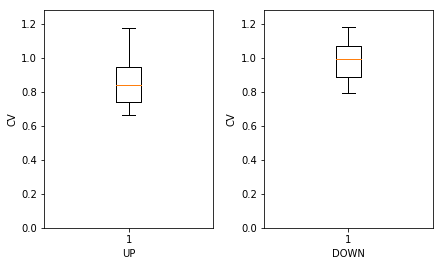

In [10]:
mean_ud_sccs, mean_du_sccs, mean_mean_up, mean_mean_down, mean_cv_up, mean_cv_down = segment_scc(20, 0.8, 0.7, 50, 0.01, 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/spiking_data/rounded_spikes_0.01', 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/UpDownTimes_data')

plot_sccs(mean_ud_sccs, mean_du_sccs)
mean_plot(mean_mean_up, mean_mean_down)
cv_plot(mean_cv_up, mean_cv_down)

No Crossings found
No Crossings found


C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


No Crossings found
No Crossings found
Total number of SWS periods:  62
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  22
Total number of SWS periods:  54
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  41
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
Total number of SWS periods:  47
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  19
No Crossings found
No Crossings found
No Crossings found
Total number of SWS periods:  46
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  24
Total number of SWS periods:  18
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  11
Total number of SWS periods:  17
Minimum number of Up states to calculate SCC:  50
Total number of long enough sw

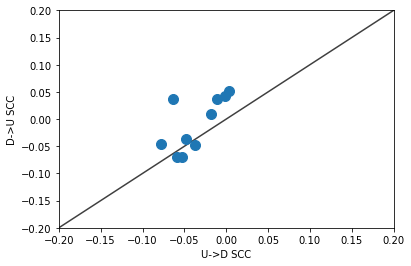

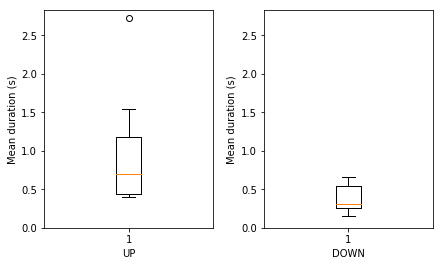

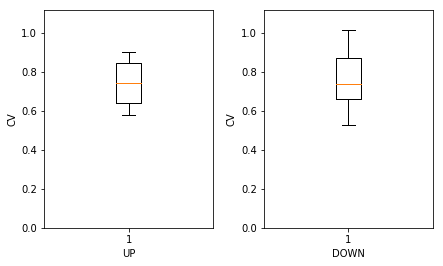

In [11]:
mean_ud_sccs, mean_du_sccs, mean_mean_up, mean_mean_down, mean_cv_up, mean_cv_down = segment_scc(20, 0.8, 0.3, 50, 0.01, 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/spiking_data/rounded_spikes_0.01', 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/UpDownTimes_data')

plot_sccs(mean_ud_sccs, mean_du_sccs)
mean_plot(mean_mean_up, mean_mean_down)
cv_plot(mean_cv_up, mean_cv_down)

No Crossings found
No Crossings found
No Crossings found
No Crossings found


C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Total number of SWS periods:  62
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  30
Total number of SWS periods:  54
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  43
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
Total number of SWS periods:  47
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  20
No Crossings found
Total number of SWS periods:  46
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  32
Total number of SWS periods:  18
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  16
Total number of SWS periods:  17
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  12
No Crossings found
No Crossings found
Total number of SWS per

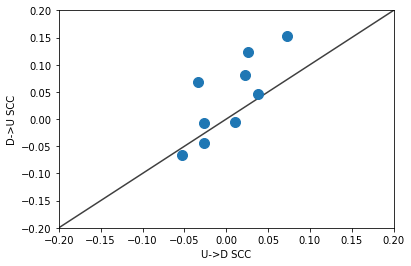

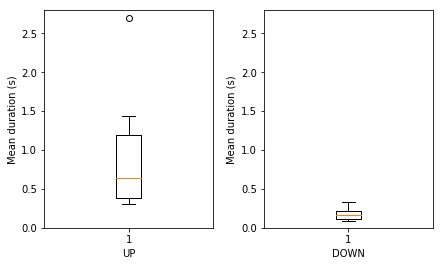

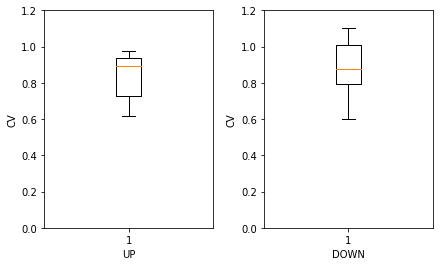

In [12]:
mean_ud_sccs, mean_du_sccs, mean_mean_up, mean_mean_down, mean_cv_up, mean_cv_down = segment_scc(20, 0.4, 0.3, 50, 0.01, 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/spiking_data/rounded_spikes_0.01', 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/UpDownTimes_data')

plot_sccs(mean_ud_sccs, mean_du_sccs)
mean_plot(mean_mean_up, mean_mean_down)
cv_plot(mean_cv_up, mean_cv_down)

No Crossings found


C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
Total number of SWS periods:  62
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  10
No Crossings found
Total number of SWS periods:  54
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  40
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
Total number of SWS periods:  47
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  12
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
Total number of SWS periods:  46
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  18
Total number of SWS periods:  18
Minimum number of 

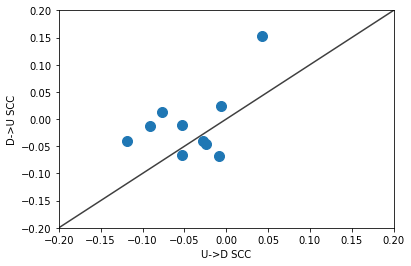

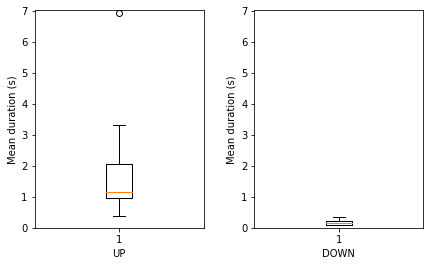

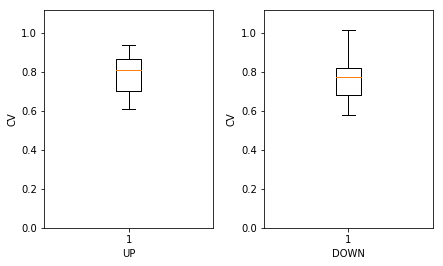

In [13]:
mean_ud_sccs, mean_du_sccs, mean_mean_up, mean_mean_down, mean_cv_up, mean_cv_down = segment_scc(20, 0.2, 0.1, 50, 0.01, 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/spiking_data/rounded_spikes_0.01', 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/UpDownTimes_data')

plot_sccs(mean_ud_sccs, mean_du_sccs)
mean_plot(mean_mean_up, mean_mean_down)
cv_plot(mean_cv_up, mean_cv_down)

No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found


C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
Total number of SWS periods:  62
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  0
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
Total number of SWS periods:  54
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  19
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
Total number of SWS periods:  46
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  13
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossi

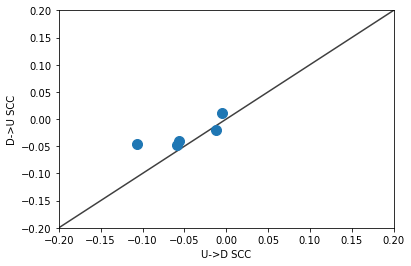

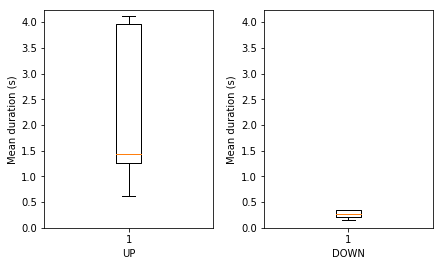

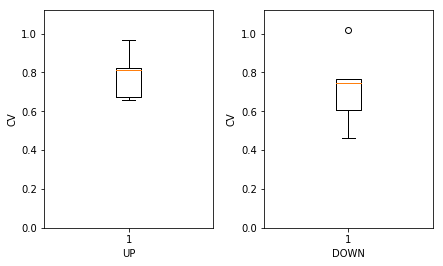

In [19]:
mean_ud_sccs, mean_du_sccs, mean_mean_up, mean_mean_down, mean_cv_up, mean_cv_down = segment_scc(30, 0.3, 0.1, 50, 0.01, 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/spiking_data/rounded_spikes_0.01', 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/UpDownTimes_data')

plot_sccs(mean_ud_sccs, mean_du_sccs)
mean_plot(mean_mean_up, mean_mean_down)
cv_plot(mean_cv_up, mean_cv_down)

No Crossings found
No Crossings found
No Crossings found
Total number of SWS periods:  62
Minimum number of Up states to calculate SCC:  50


C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Total number of long enough sws periods:  31
Total number of SWS periods:  54
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  39
No Crossings found
No Crossings found
No Crossings found
No Crossings found
Total number of SWS periods:  47
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  27
No Crossings found
No Crossings found
Total number of SWS periods:  105
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  56
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
Total number of SWS periods:  46
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  0
Total number of SWS periods:  18
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  7
No Crossings found
Total number of SWS periods:  16
Minimum number of Up states to calcu

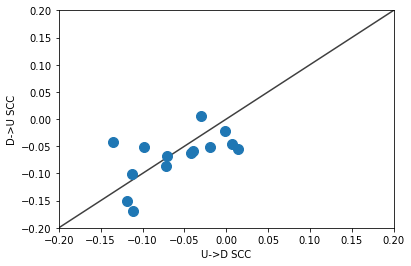

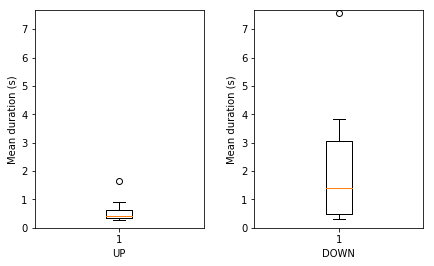

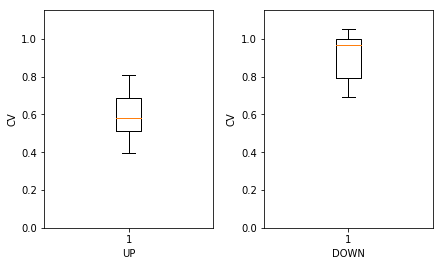

In [17]:
mean_ud_sccs, mean_du_sccs, mean_mean_up, mean_mean_down, mean_cv_up, mean_cv_down = segment_scc(30, 1.5, 1.0, 50, 0.01, 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/spiking_data/rounded_spikes_0.01', 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/UpDownTimes_data')

plot_sccs(mean_ud_sccs, mean_du_sccs)
mean_plot(mean_mean_up, mean_mean_down)
cv_plot(mean_cv_up, mean_cv_down)

No Crossings found


C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
Total number of SWS periods:  62
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  12
Total number of SWS periods:  54
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  32
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
Total number of SWS periods:  47
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  17
No Crossings found
No Crossings found
No Crossings found
No Crossings found
Total number of SWS periods:  105
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  48
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
Total number

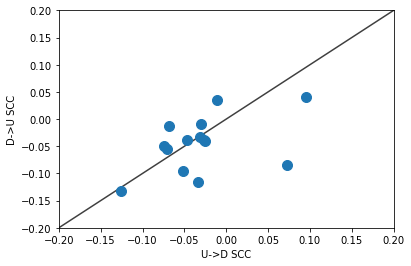

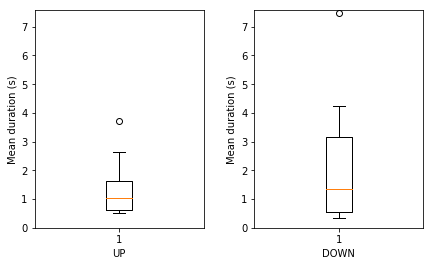

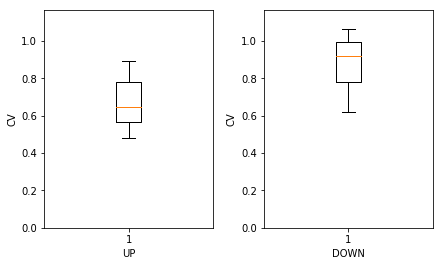

In [18]:
mean_ud_sccs, mean_du_sccs, mean_mean_up, mean_mean_down, mean_cv_up, mean_cv_down = segment_scc(30, 1.5, 0.5, 50, 0.01, 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/spiking_data/rounded_spikes_0.01', 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/UpDownTimes_data')

plot_sccs(mean_ud_sccs, mean_du_sccs)
mean_plot(mean_mean_up, mean_mean_down)
cv_plot(mean_cv_up, mean_cv_down)

No Crossings found


C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Total number of SWS periods:  62
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  38
Total number of SWS periods:  54
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  44
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
Total number of SWS periods:  47
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  25
No Crossings found
Total number of SWS periods:  105
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  81
No Crossings found
No Crossings found
Total number of SWS periods:  46
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  26
Total number of SWS periods:  18
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  11
No Crossings found
Total number of SWS pe

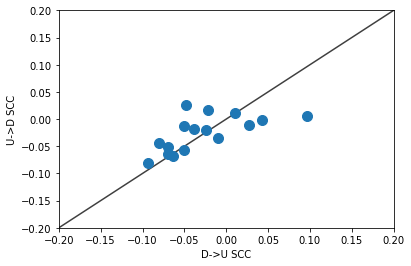

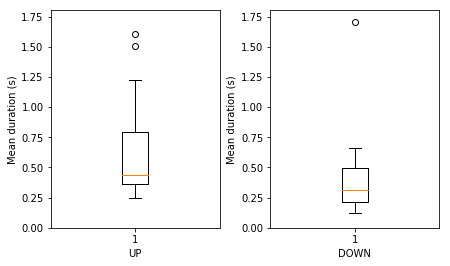

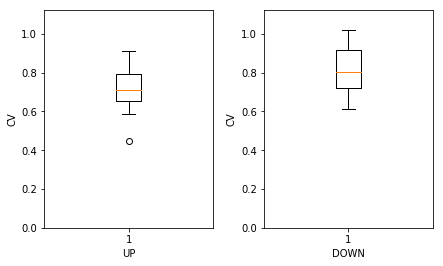

In [10]:
mean_ud_sccs, mean_du_sccs, mean_mean_up, mean_mean_down, mean_cv_up, mean_cv_down = segment_scc(20, 0.8, 0.5, 50, 0.01, 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/spiking_data/rounded_spikes_0.01', 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/UpDownTimes_data')

plot_sccs(mean_ud_sccs, mean_du_sccs)
mean_plot(mean_mean_up, mean_mean_down)
cv_plot(mean_cv_up, mean_cv_down)

No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found


C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
Total number of SWS periods:  62
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  0
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
Total number of SWS periods:  54
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  18
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No C

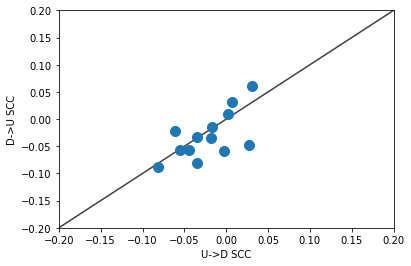

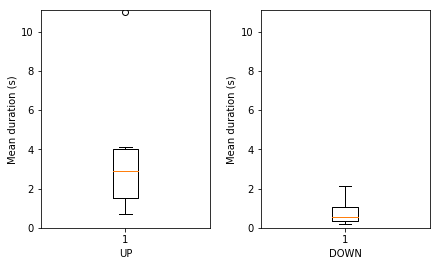

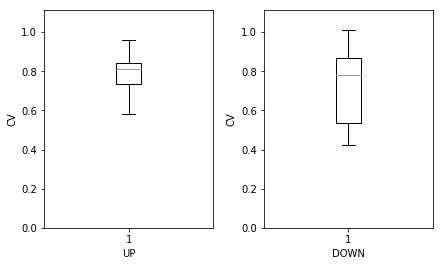

In [20]:
mean_ud_sccs, mean_du_sccs, mean_mean_up, mean_mean_down, mean_cv_up, mean_cv_down = segment_scc(30, 0.8, 0.1, 50, 0.01, 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/spiking_data/rounded_spikes_0.01', 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/UpDownTimes_data')

plot_sccs(mean_ud_sccs, mean_du_sccs)
mean_plot(mean_mean_up, mean_mean_down)
cv_plot(mean_cv_up, mean_cv_down)

No Crossings found
No Crossings found


C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\Shoshana\Anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Total number of SWS periods:  62
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  36
Total number of SWS periods:  54
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  45
No Crossings found
No Crossings found
No Crossings found
No Crossings found
No Crossings found
Total number of SWS periods:  47
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  29
No Crossings found
Total number of SWS periods:  105
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  90
No Crossings found
Total number of SWS periods:  46
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  34
Total number of SWS periods:  18
Minimum number of Up states to calculate SCC:  50
Total number of long enough sws periods:  17
No Crossings found
Total number of SWS periods:  16
Minimum number of Up states to calculate SCC: 

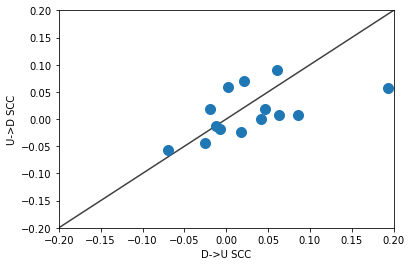

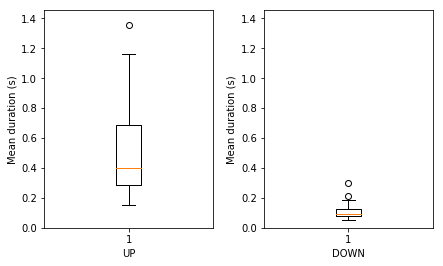

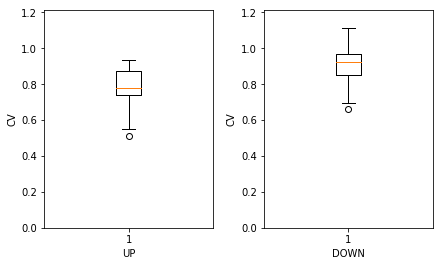

In [9]:
mean_ud_sccs, mean_du_sccs, mean_mean_up, mean_mean_down, mean_cv_up, mean_cv_down = segment_scc(10, 0.2, 0.1, 50, 0.01, 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/spiking_data/rounded_spikes_0.01', 'C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/UpDownTimes_data')

plot_sccs(mean_ud_sccs, mean_du_sccs)
mean_plot(mean_mean_up, mean_mean_down)
cv_plot(mean_cv_up, mean_cv_down)

In [ ]:
# UPDATE: Just look at Levenstein segmentation statistics notebook file for this

# Plot SCCs of all the already-segmented Levenstein data

# For every recording:
    # Load the Up state start/stop times file, Down state start/stop times file, and SWS start/stop times file I create
    # For every SWS interval:
        # Check that it has the minimum number of Up/Down states
        # Calculate the U->D and D->U SCCs and store them
    # Calculate the mean of the U->D SCCs and D->U SCCs from all the SWS intervals, and store these two numbers
# Use matplotlib (transfer my R code) to create plots with U->D and D->U SCCs on the different axes, continuous color based on number of states detected within period, and the y=x line plotted


def Levenstein_segmentation_scc_plot(num_ups_min):

    mean_ud_sccs = []
    mean_du_sccs = []
    all_num_ups = []
        
    for root, dirs, files in os.walk('C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/UpDownTimes_data'):
        if len(files) == 3:
            down_file = os.path.join(root, files[0])
            sws_file = os.path.join(root, files[1])
            up_file = os.path.join(root, files[2])
    
            # Load data
            up_times_list = list(csv.reader(open(up_file)))
            down_times_list = list(csv.reader(open(down_file)))
            sws_times_list = list(csv.reader(open(sws_file)))
            up_times = np.array(up_times_list)
            down_times = np.array(down_times_list)
            sws_times = np.array(sws_times_list)
    
            # Initialize arrays for storing information for plotting
            ud_recording = []
            du_recording = []
            num_ups = []

            for swEpisode in sws_times[1:]:
                sws_start = float(swEpisode[0])
                sws_stop = float(swEpisode[1])

                # Calculate Up and Down durations
                UP_dur = []
                DOWN_dur = []
                for timePair in up_times[1:]:
                    state_start = float(timePair[0])
                    state_stop = float(timePair[1])
                    if state_start >= sws_start and state_stop <= sws_stop:
                        dur = state_stop - state_start
                        UP_dur.append(dur)
                for timePair in down_times[1:]:
                    state_start = float(timePair[0])
                    state_stop = float(timePair[1])
                    if state_start >= sws_start and state_stop <= sws_stop:
                        dur = state_stop - state_start
                        DOWN_dur.append(dur)

                # Calculate SCCs for all long enough SWS intervals
                if len(UP_dur) > num_ups_min: #only calculate SCCs for SWS periods with enough detected states
                    # first get the up and down duration arrays to be the same length (get rid of states if there's an extra of one)
                    up_array = np.array(UP_dur)
                    down_array = np.array(DOWN_dur)
                    if len(up_array) == len(down_array) - 1:
                        down_array = down_array[:-1]
                    elif len(up_array) == len(down_array) + 1:
                        up_array = up_array[:-1]
                    elif len(up_array) == len(down_array) - 2:
                        down_array = down_array[:-2]
                    elif len(up_array) == len(down_array) + 2:
                        up_array = up_array[:-2]
    
                    # Do the calculations:
                    ud = segmentation_stats.SCC(up_array, down_array, 1)
                    du = segmentation_stats.SCC(up_array, down_array, 0)
    
                    if math.isnan(ud) == False & math.isnan(du) == False:
                        ud_recording.append(ud)
                        du_recording.append(du)
                        all_num_ups.append(len(UP_dur))
            
            # Calculate the mean SCCs for this recording:
            mean_ud = statistics.mean(ud_recording)
            mean_du = statistics.mean(du_recording)
            mean_ud_sccs.append(mean_ud)
            mean_du_sccs.append(mean_du)
    
    # Plotting:
    fig, ax = plt.subplots()
    #plt.scatter(mean_ud_sccs[1:], mean_du_sccs[1:], s = 100) #I have no idea what the first scc is in my means lists...
    plt.scatter(mean_ud_sccs, mean_du_sccs, s = 100) 
    plt.xlabel("U->D SCC")
    plt.ylabel("D->U SCC")
    lims = [-0.1, 0.2]
    #lims = [
    #    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    #    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    #]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    print("Number of long enough SWS periods: ", len(all_num_ups))


In [35]:
# Plot Means and CVs of all the already-segmented Levenstein data

# For every recording:
    # Load the Up state start/stop times file, Down state start/stop times file, and SWS start/stop times file I create
    # For every SWS interval:
        # Check that it has the minimum number of Up/Down states
        # Calculate the U->D and D->U SCCs and store them
    # Calculate the mean of the U->D SCCs and D->U SCCs from all the SWS intervals, and store these two numbers
# Use matplotlib (transfer my R code) to create plots with U->D and D->U SCCs on the different axes, continuous color based on number of states detected within period, and the y=x line plotted


def Levenstein_segmentation_meancv_plot():

    mean_up_list = []
    cv_up_list = []
    mean_down_list = []
    cv_down_list = []
        
    for root, dirs, files in os.walk('C:/Users/Shoshana/Documents/CSHL Summer/Data_CSVs/UpDownTimes_data'):
        if len(files) == 3:
            down_file = os.path.join(root, files[0])
            up_file = os.path.join(root, files[2])
    
            # Load data
            up_times_list = list(csv.reader(open(up_file)))
            down_times_list = list(csv.reader(open(down_file)))
            up_times = np.array(up_times_list)
            down_times = np.array(down_times_list)
    

            # Calculate Up and Down durations for this SWS period
            UP_dur = []
            DOWN_dur = []
            for timePair in up_times[1:]:
                state_start = float(timePair[0])
                state_stop = float(timePair[1])
                dur = state_stop - state_start
                UP_dur.append(dur)
            for timePair in down_times[1:]:
                state_start = float(timePair[0])
                state_stop = float(timePair[1])
                dur = state_stop - state_start
                DOWN_dur.append(dur)
                              
            # Calculate mean and CV using all data:
            mean_up, cv_up, mean_down, cv_down = segmentation_stats.mean_cv(UP_dur, DOWN_dur)
            mean_up_list.append(mean_up)
            cv_up_list.append(cv_up)
            mean_down_list.append(mean_down)
            cv_down_list.append(cv_down)

            
    
    # Plotting:
    mean_plot(mean_up_list, mean_down_list)
    cv_plot(cv_up_list, cv_down_list)




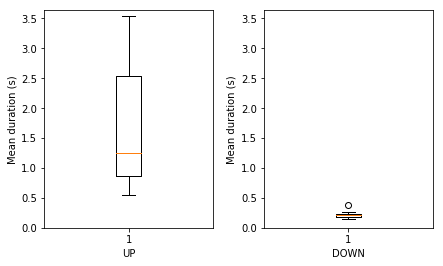

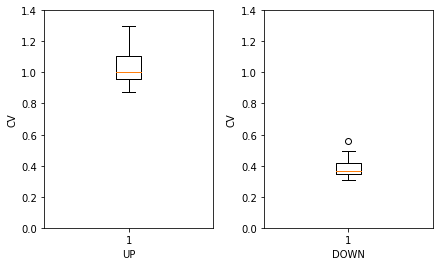

In [36]:
Levenstein_segmentation_meancv_plot()